<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson02_SGD_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lesson 2**. Simple SGD(stochastic gradient descent) excercise

1.Improve Leason 1's code. Speed up the gradient descent effective.

2.Generalize leason 1's self-design DNN code.

3.Use self-implement of DNN and SGD code to train a multiple layers DNN.

4.Design a multiple-class classification excerise.

5.Compare your code with the Pytorch's implement.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features_and_labels(features, labels, size_of_class, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()


def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[0]
    split_index = int(m * split_rate)

    indices = np.array(range(m))
    np.random.shuffle(indices)

    train_indices, test_indices = np.array(indices[0:split_index]), np.array(indices[split_index:])
    train_features, train_labels = feature_matrix[train_indices, :], label_matrix[train_indices, :]
    test_features, test_labels = feature_matrix[test_indices, :], label_matrix[test_indices, :]

    return train_features, train_labels, test_features, test_labels


def draw_neuron_boundary(neuron, features, labels, markers, colors, grid_step=0.5, size_of_class= 2):
    min_x, max_x = np.min(features[:, 0]), np.max(features[:, 0])
    min_y, max_y = np.min(features[:, 1]), np.max(features[:, 1])

    xx, yy = np.meshgrid(np.arange(min_x - 1, max_x + 1, grid_step), np.arange(min_y - 1, max_y + 1, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    predict = neuron.predict(grid_points)
    argmax_index = np.argmax(predict, axis=1)

    positive_index = grid_points[np.where(argmax_index == 0), :]
    negative_index = grid_points[np.where(argmax_index == 1), :]

    plt.figure(figsize=(4, 4))
    for i in range(size_of_class):
        class_index = grid_points[np.where(argmax_index == i), :]
        plt.scatter(class_index[0, :, 0], class_index[0, :, 1], c=colors[i], alpha=0.1)

    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

# Exercise 1
## 1. re-design the Simple DNN
## 2. Implement the correct SGD code
## 3. Run a simple classification problem

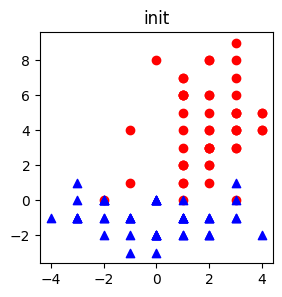

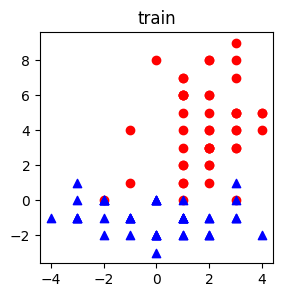

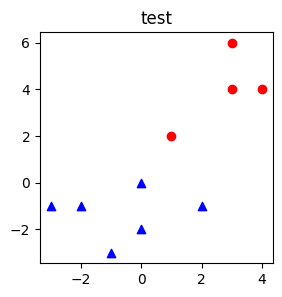

train_features shape: (90, 2)  train_labels shape: (90, 2)


In [2]:
# Generate serveral normal subsample datasets and scatter them on the figure
size_of_class = 2
size_of_sample = 50
size_of_feature = 2
means = [(2,4), (0,-1), (-2,3)]
vars = [[[2,0], [0,5]], [[4,0], [0,1]], [[3,0],[0,3]]]
#markers = ['o', '*', '^']
#colors = ['r', 'g', 'b']
markers = ['o', '^']
colors = ['r', 'b']

labels = []
features = []
for i in range(size_of_class):
    label = np.zeros((size_of_sample, size_of_class))
    label[:, i] = 1.
    feature = np.round(np.random.multivariate_normal(means[i], vars[i], size_of_sample))

    labels.append(label)
    features.append(feature)

labels = np.concatenate(labels, axis=0)
features = np.concatenate(features, axis=0)

train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')
print('train_features shape:',train_features.shape, ' train_labels shape:', train_labels.shape)

In [3]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H


class SimpleDNN:
    def __init__(self, size_of_feature, size_of_class):
        self.L1 = Linear(in_size=size_of_feature, out_size=1)
        self.A1 = Sigmoid_Active_Function()
        self.L2 = Linear(in_size=1, out_size=size_of_class)

    def forward(self, X):
        Z = self.L2.forward(self.A1.forward(self.L1.forward(X)))
        return Z

    def backward(self, E):
        dLoss_by_dL2 = self.L2.backward(E)
        dLoss_by_dA1 = self.A1.backward(dLoss_by_dL2)
        dLoss_by_dL1 = self.L1.backward(dLoss_by_dA1)
        return dLoss_by_dL1

    def predict(self, X):
        Z = self.L2.predict(self.A1.predict(self.L1.predict(X)))
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        self.L2.update_weights(learning_rate)
        self.L1.update_weights(learning_rate)


class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        self.Y_hat = self.process_function(Z)
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

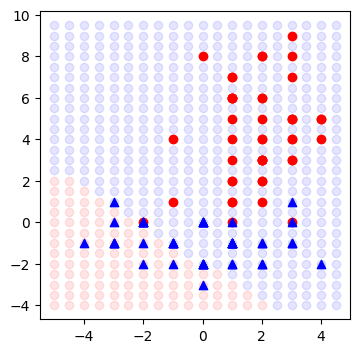

Epoch 1
-------------------------------
loss : 1.0273096161405437


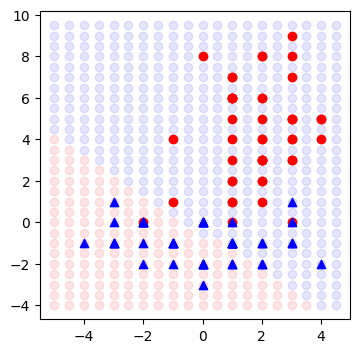

loss : 0.5780393286557743


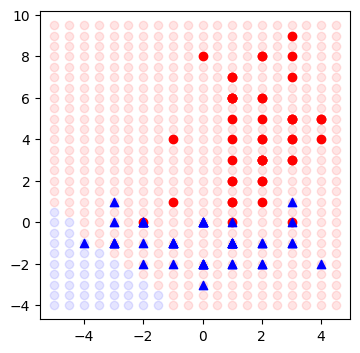

Epoch 2
-------------------------------
loss : 0.5148603334025349


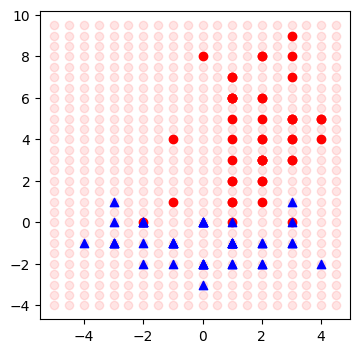

loss : 0.39216831761436766


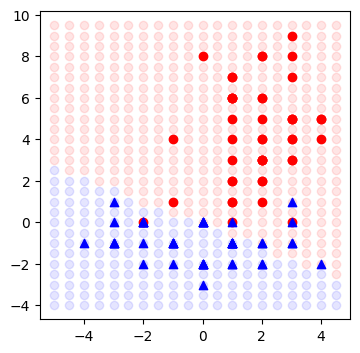

Epoch 3
-------------------------------
loss : 0.3577179749657884


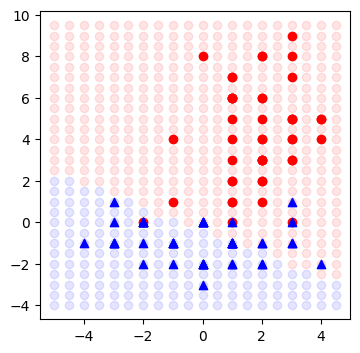

loss : 0.22739103211550202


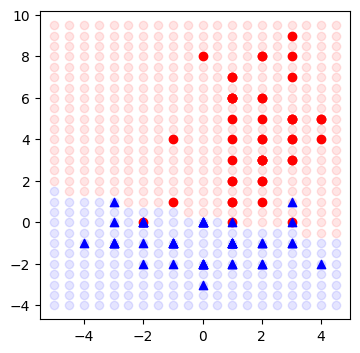

Epoch 4
-------------------------------
loss : 0.21320155507489053


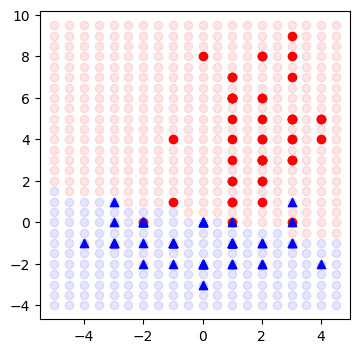

loss : 0.1427165159202688


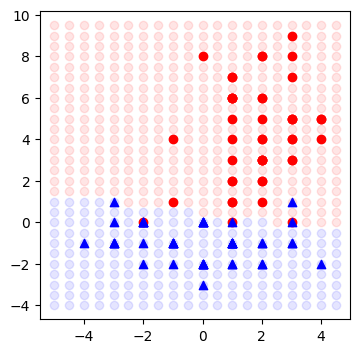

Epoch 5
-------------------------------
loss : 0.13666096251222992


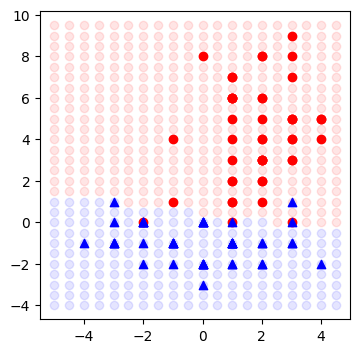

loss : 0.10025150694489002


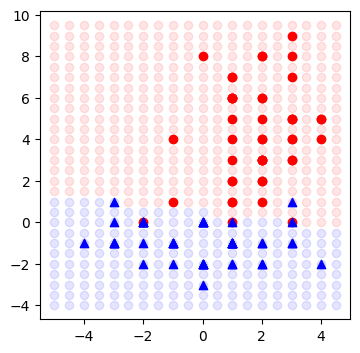

Epoch 6
-------------------------------
loss : 0.09718202335033219


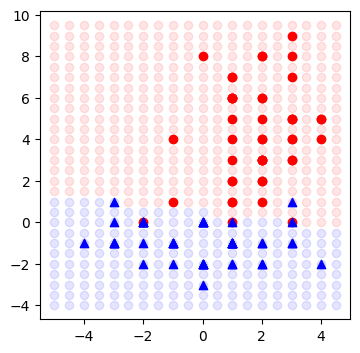

loss : 0.07663383424880789


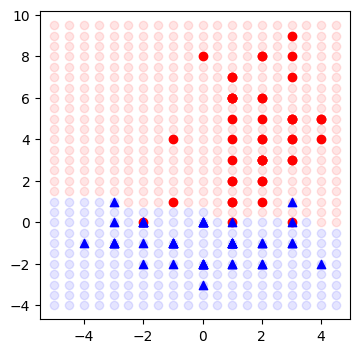

Epoch 7
-------------------------------
loss : 0.0748222341667259


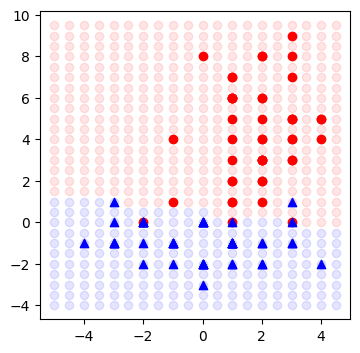

loss : 0.06222156796989904


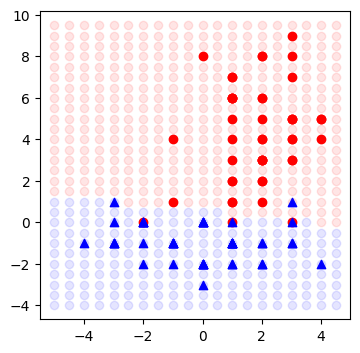

Epoch 8
-------------------------------
loss : 0.061018870954093564


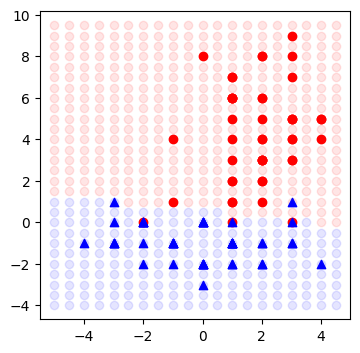

loss : 0.05281240274605353


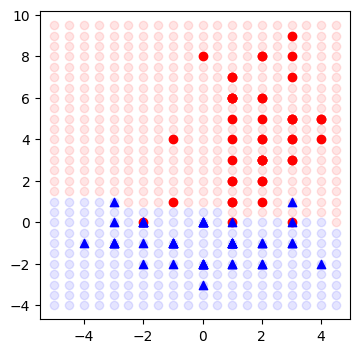

Epoch 9
-------------------------------
loss : 0.05193871971923581


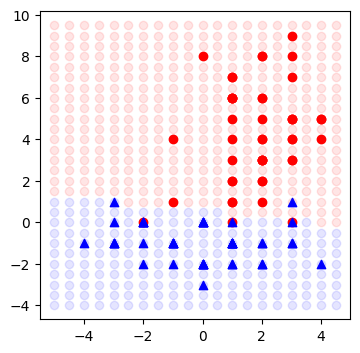

loss : 0.04636157432715437


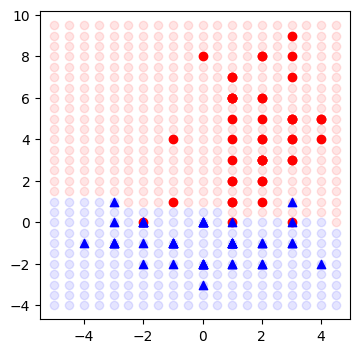

Epoch 10
-------------------------------
loss : 0.045681494311021247


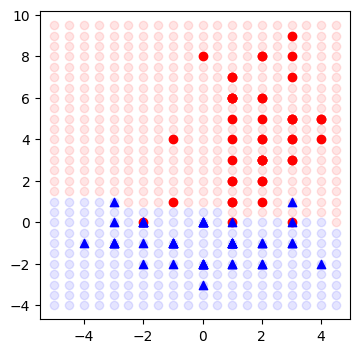

loss : 0.04177126129351012


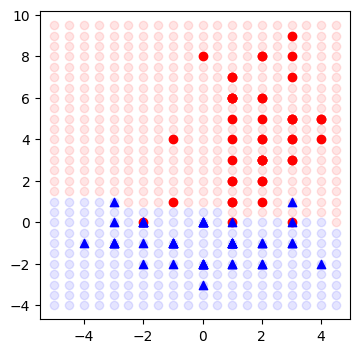

Epoch 11
-------------------------------
loss : 0.04121297704609655


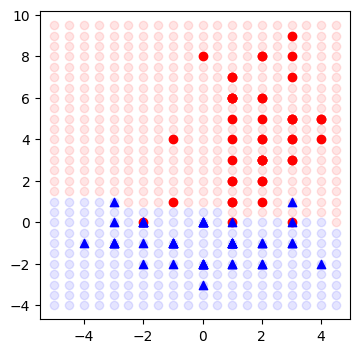

loss : 0.03840888957759437


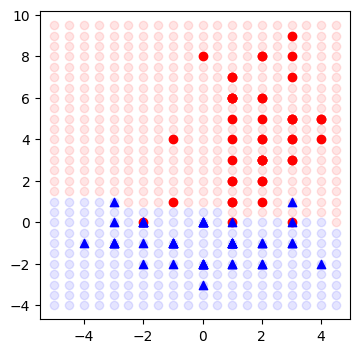

Epoch 12
-------------------------------
loss : 0.03793132218816091


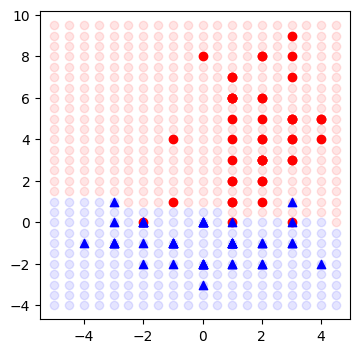

loss : 0.03589049160648062


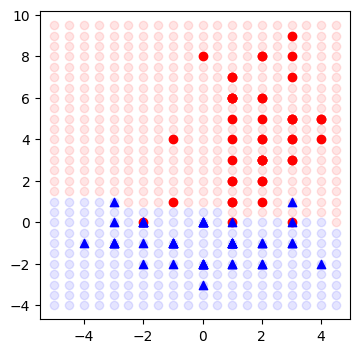

Epoch 13
-------------------------------
loss : 0.035468583848308435


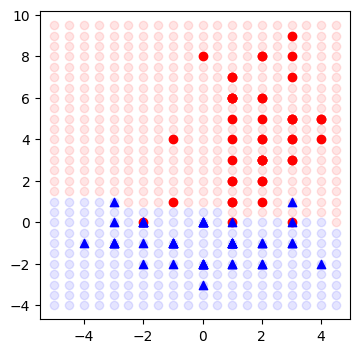

loss : 0.03397282381760161


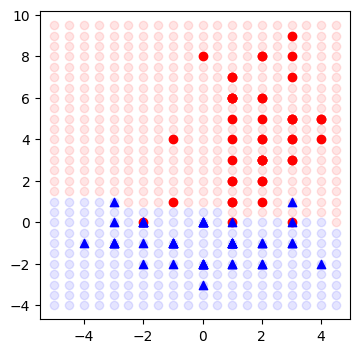

Epoch 14
-------------------------------
loss : 0.033590434591023455


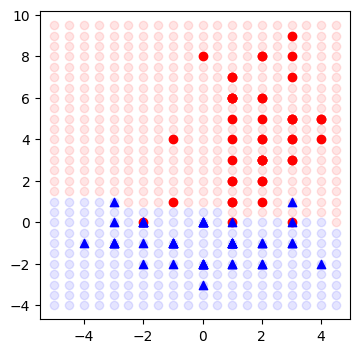

loss : 0.03249584631061453


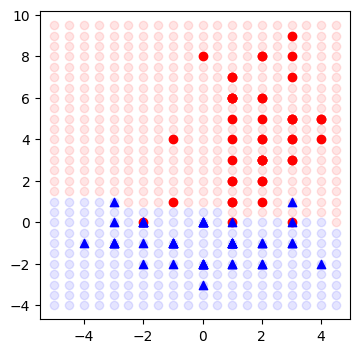

Epoch 15
-------------------------------
loss : 0.03214208655925232


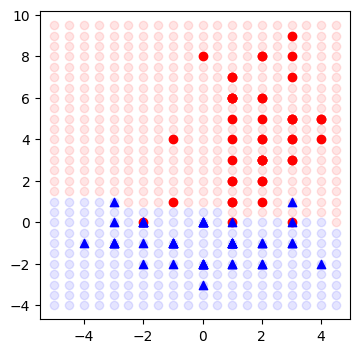

loss : 0.03135053082287452


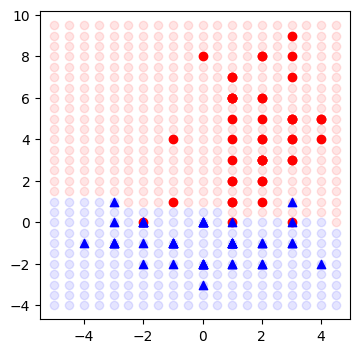

Epoch 16
-------------------------------
loss : 0.031017764700180656


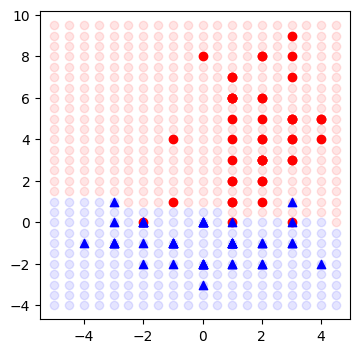

loss : 0.030460127591963378


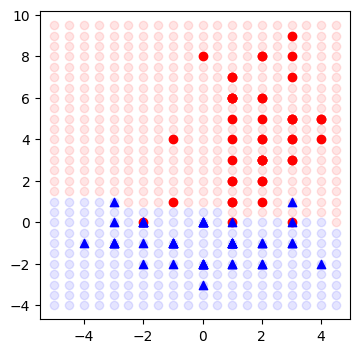

Epoch 17
-------------------------------
loss : 0.030142827573201223


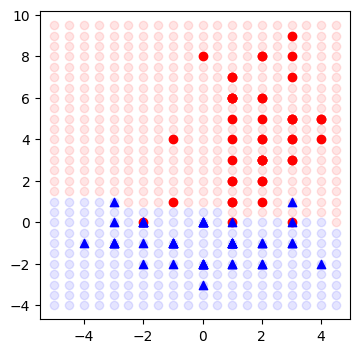

loss : 0.029768892414597004


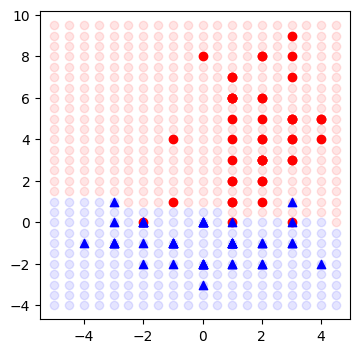

Epoch 18
-------------------------------
loss : 0.029462955256211565


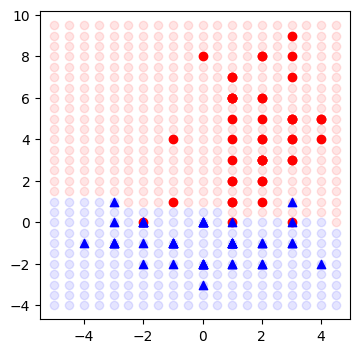

loss : 0.029235105366003752


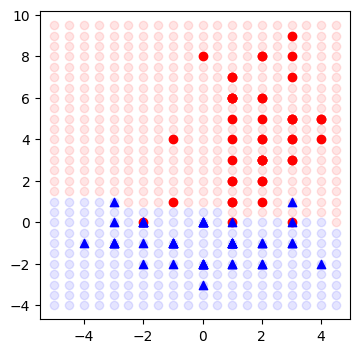

Epoch 19
-------------------------------
loss : 0.02893742802432932


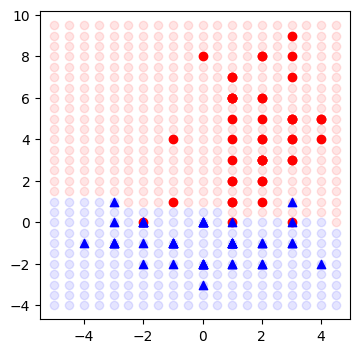

loss : 0.028826646980681627


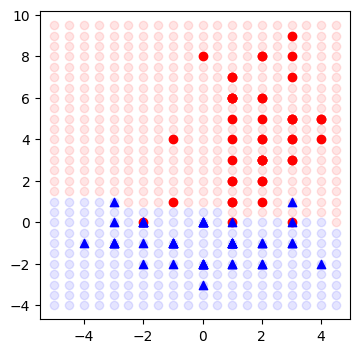

Epoch 20
-------------------------------
loss : 0.02853485469319706


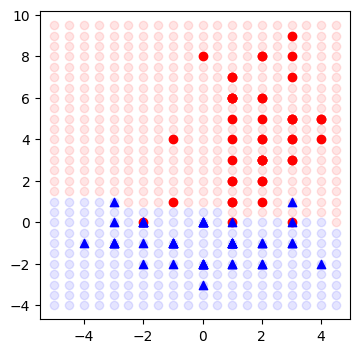

loss : 0.028518150632219266


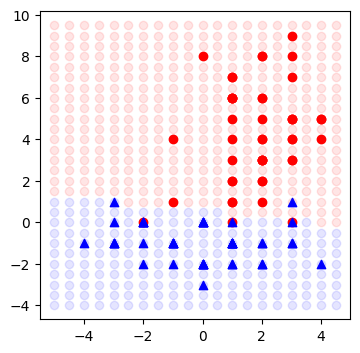

In [4]:
demo_neuron = SimpleDNN(2, 2)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.5, 2)

epochs = 20
m = train_labels.shape[0]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.1)

        if iter_id % (m-1) == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.5, 2)

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

train_X = torch.Tensor(train_features)
train_y = torch.Tensor(train_labels)
train_dataset = TensorDataset(train_X, train_y)
train_dataloader = DataLoader(train_dataset)

test_X = torch.Tensor(test_features) # transform to torch tensor
test_y = torch.Tensor(test_labels)
test_dataset = TensorDataset(test_X, test_y)
test_dataloader = DataLoader(test_dataset)

# Learn to use pytorch to build the same nn to compare with the self-implement NN

class TorchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features = 2, out_features = 1, bias = True)
        self.A = nn.Sigmoid()
        self.output = nn.Linear(in_features = 1, out_features = 2, bias = True)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.output(self.A(self.fc1(x)))
        return logits

    def show_weights(self):
        #print(self.fc1.weight.data, self.fc1.bias.data,  self.output.weight.data, self.output.bias.data)
        return

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            #draw_neuron_boundary_2(model.fc1.weight.data, model.fc1.bias.data, train_features, train_labels, markers, colors)
            #model.show_weights()

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


tNN = TorchNN()
print(tNN)

#loss_function = nn.MSELoss()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(tNN.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, tNN, loss_function, optimizer)
    #tNN.show_weights()
    test_loop(test_dataloader, tNN, loss_function)
print("Done!")




TorchNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2, out_features=1, bias=True)
  (A): Sigmoid()
  (output): Linear(in_features=1, out_features=2, bias=True)
)
Epoch 1
-------------------------------
loss: 0.729335  [    1/   90]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.744236 

Epoch 2
-------------------------------
loss: 0.655554  [    1/   90]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.730240 

Epoch 3
-------------------------------
loss: 0.627086  [    1/   90]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.718849 

Epoch 4
-------------------------------
loss: 0.617823  [    1/   90]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.708593 

Epoch 5
-------------------------------
loss: 0.614888  [    1/   90]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.697962 

Epoch 6
-------------------------------
loss: 0.611237  [    1/   90]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.685395 

Epoch 7
-------------------------------
loss: 0.602652  [    1/   90]

# Exercise 2
## 1. Implement a multiple classes classification problem
## 2. Reuse your implenent of linear layer, sigmoid active function, cross entropy loss function and back probagation.

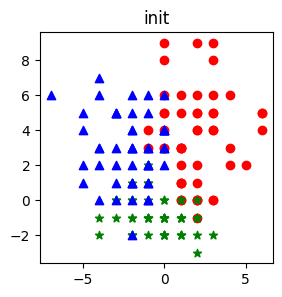

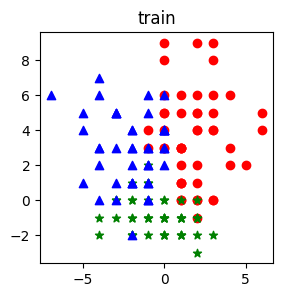

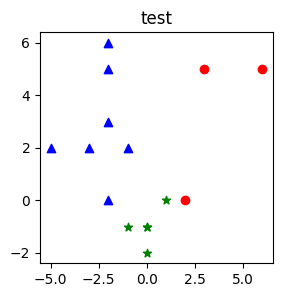

train_features shape: (135, 2)  train_labels shape: (135, 3)


In [6]:
# Generate serveral normal subsample datasets and scatter them on the figure
size_of_class = 3
size_of_sample = 50
size_of_feature = 2
means = [(2,4), (0,-1), (-2,3)]
vars = [[[2,0], [0,5]], [[4,0], [0,1]], [[3,0],[0,3]]]
markers = ['o', '*', '^']
colors = ['r', 'g', 'b']

labels = []
features = []
for i in range(size_of_class):
    label = np.zeros((size_of_sample, size_of_class))
    label[:, i] = 1.
    feature = np.round(np.random.multivariate_normal(means[i], vars[i], size_of_sample))

    labels.append(label)
    features.append(feature)

labels = np.concatenate(labels, axis=0)
features = np.concatenate(features, axis=0)

train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')
print('train_features shape:',train_features.shape, ' train_labels shape:', train_labels.shape)

In [7]:
class MulClassDNN:
    def __init__(self, size_of_feature, size_of_class):
        self.L1 = Linear(in_size=size_of_feature, out_size=3)
        self.A1 = Sigmoid_Active_Function()
        self.L2 = Linear(in_size=3, out_size=3)
        self.A2 = Sigmoid_Active_Function()
        self.L3 = Linear(in_size=3, out_size=size_of_class)

    def forward(self, X):
        Z = self.L3.forward(self.A2.forward(self.L2.forward(self.A1.forward(self.L1.forward(X)))))
        return Z

    def backward(self, E):
        dLoss_by_dL3 = self.L3.backward(E)
        dLoss_by_dA2 = self.A2.backward(dLoss_by_dL3)
        dLoss_by_dL2 = self.L2.backward(dLoss_by_dA2)
        dLoss_by_dA1 = self.A1.backward(dLoss_by_dL2)
        dLoss_by_dL1 = self.L1.backward(dLoss_by_dA1)
        return dLoss_by_dL1

    def predict(self, X):
        Z = self.L3.predict(self.A2.predict(self.L2.predict(self.A1.predict(self.L1.predict(X)))))
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        self.L3.update_weights(learning_rate)
        self.L2.update_weights(learning_rate)
        self.L1.update_weights(learning_rate)

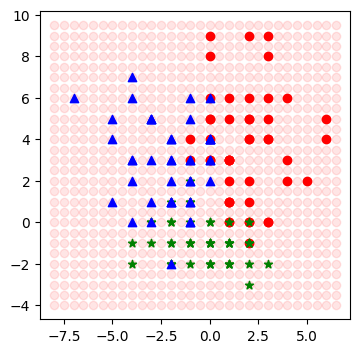

Epoch 1
-------------------------------
loss : 0.6559210015754225


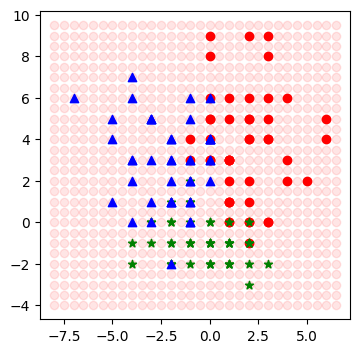

loss : 1.3033028088313154


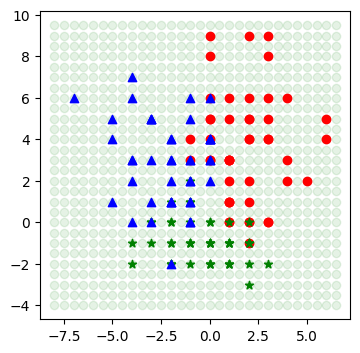

Epoch 2
-------------------------------
loss : 1.0746198550543822


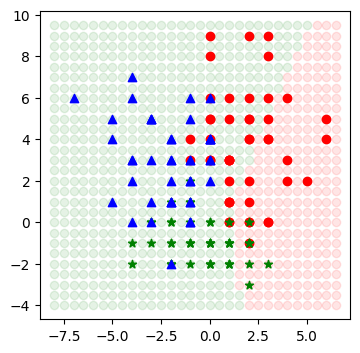

loss : 1.1565275568479247


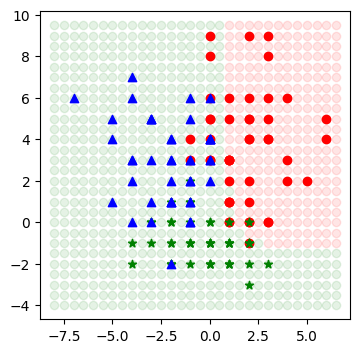

Epoch 3
-------------------------------
loss : 0.8586531556936601


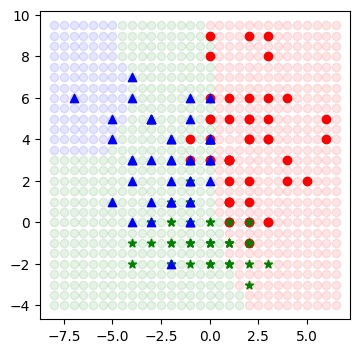

loss : 0.9754553452291411


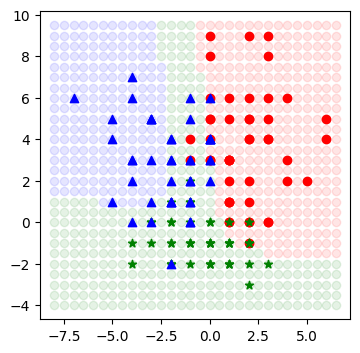

Epoch 4
-------------------------------
loss : 0.6791182202413593


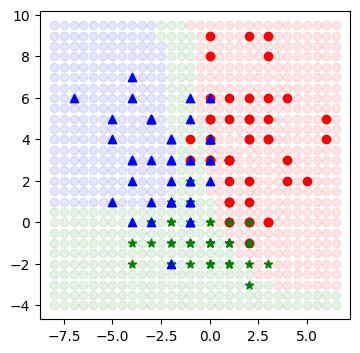

loss : 0.785793845178792


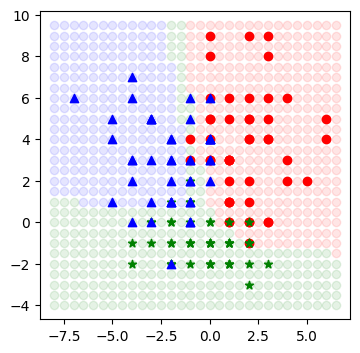

Epoch 5
-------------------------------
loss : 0.5080577208148296


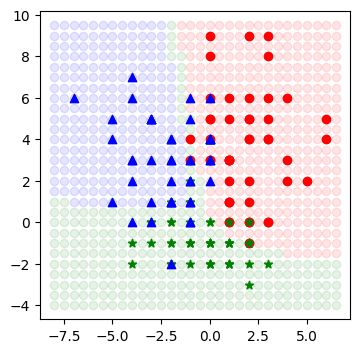

loss : 0.5944583748649424


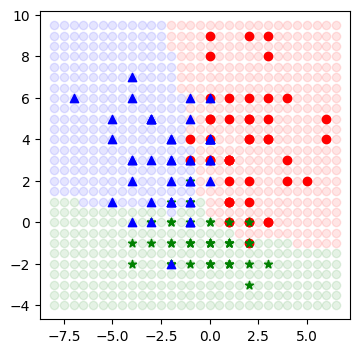

Epoch 6
-------------------------------
loss : 0.3535738971867957


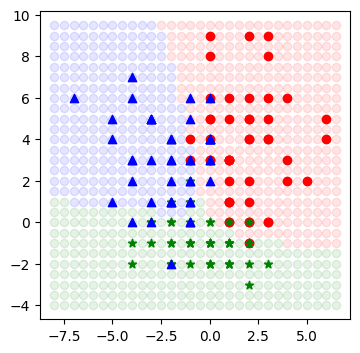

loss : 0.4687096892293451


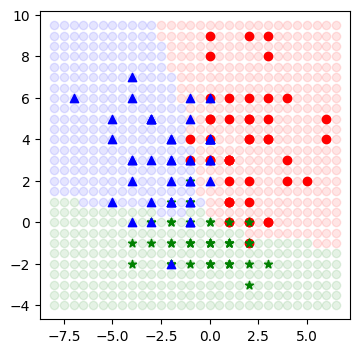

Epoch 7
-------------------------------
loss : 0.2459713473024491


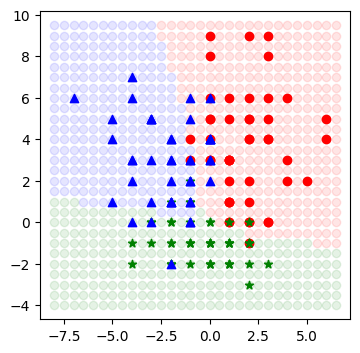

loss : 0.4044560238761088


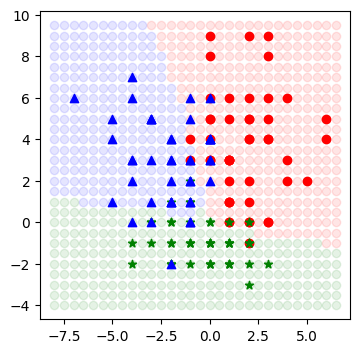

Epoch 8
-------------------------------
loss : 0.18129629241989068


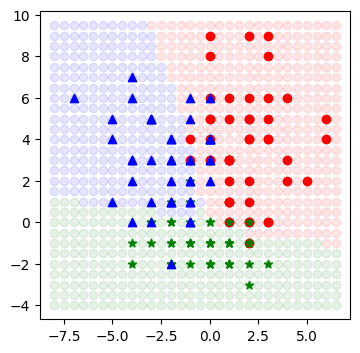

loss : 0.37530216091200935


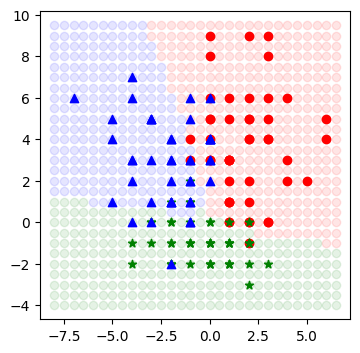

Epoch 9
-------------------------------
loss : 0.14124948370199042


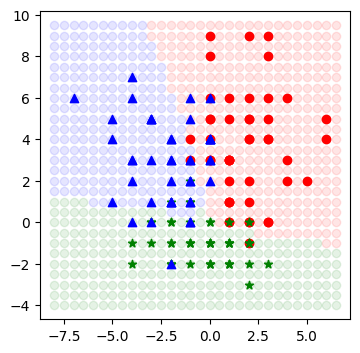

loss : 0.36287552569141523


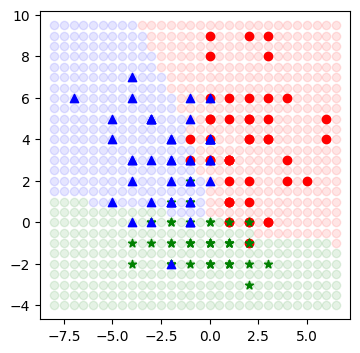

Epoch 10
-------------------------------
loss : 0.11470548018058567


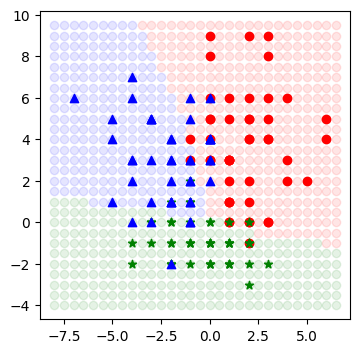

loss : 0.3577989788363067


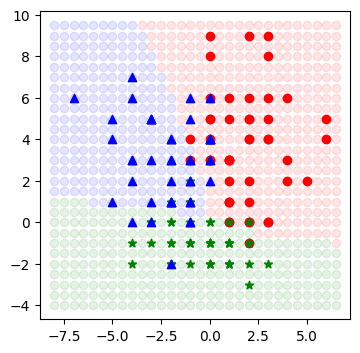

Epoch 11
-------------------------------
loss : 0.09596883981171116


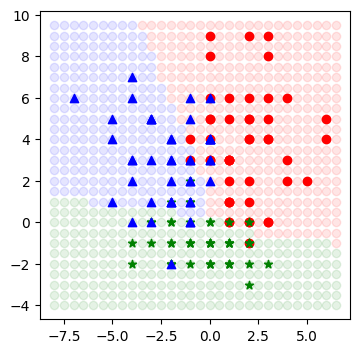

loss : 0.35614396873730886


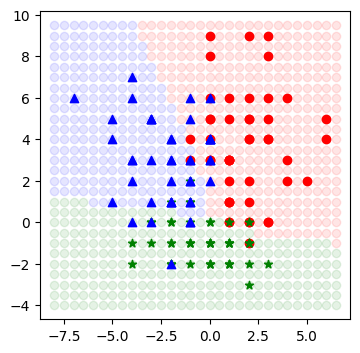

Epoch 12
-------------------------------
loss : 0.08206121573050008


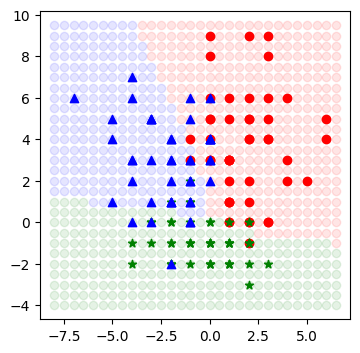

loss : 0.3563698983409906


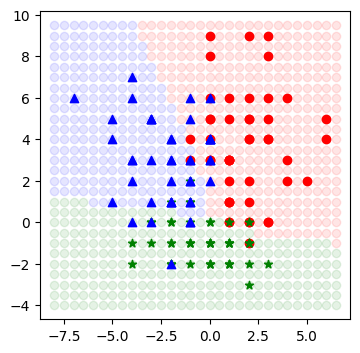

Epoch 13
-------------------------------
loss : 0.07133293896548863


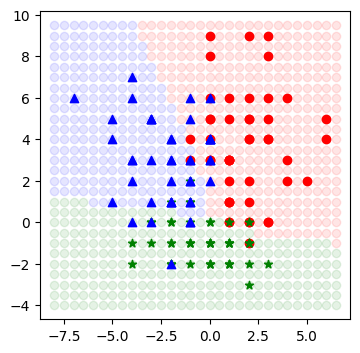

loss : 0.35775019777978934


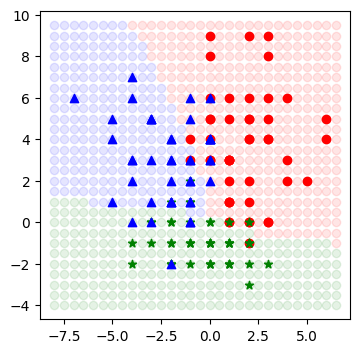

Epoch 14
-------------------------------
loss : 0.06282057075193055


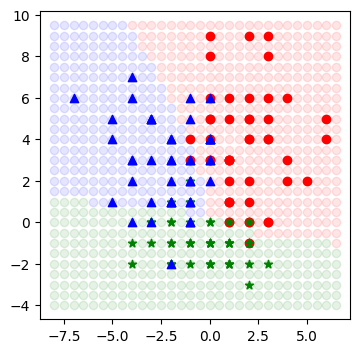

loss : 0.359800070280709


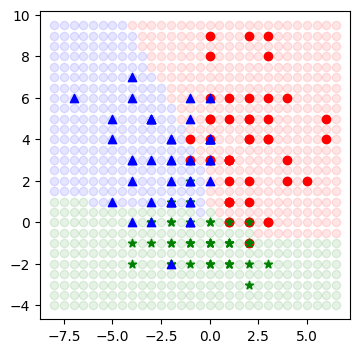

Epoch 15
-------------------------------
loss : 0.055930094105943066


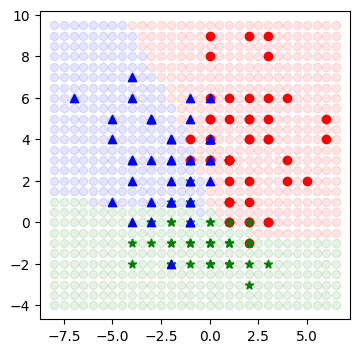

loss : 0.362081607758616


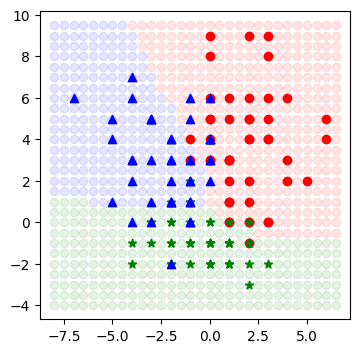

Epoch 16
-------------------------------
loss : 0.05027028712645223


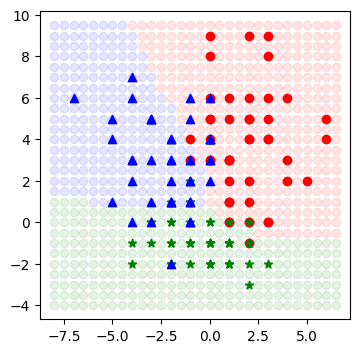

loss : 0.3641325682128452


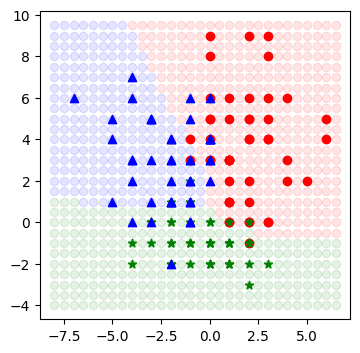

Epoch 17
-------------------------------
loss : 0.045566435220114804


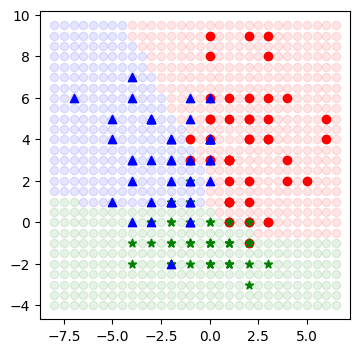

loss : 0.36549996502833776


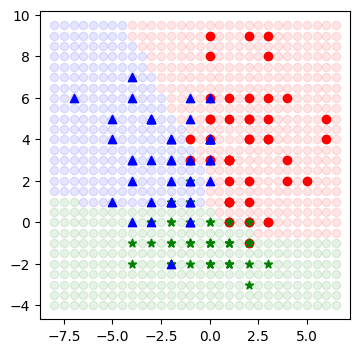

Epoch 18
-------------------------------
loss : 0.041617871881827716


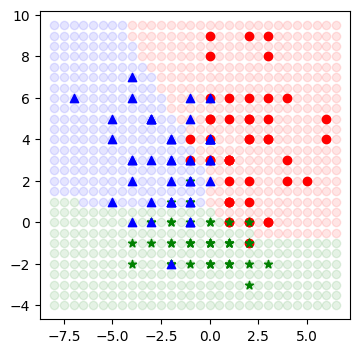

loss : 0.3658826613843651


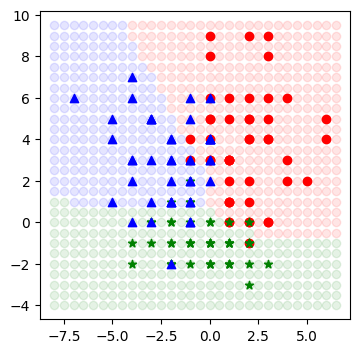

Epoch 19
-------------------------------
loss : 0.03827530247437255


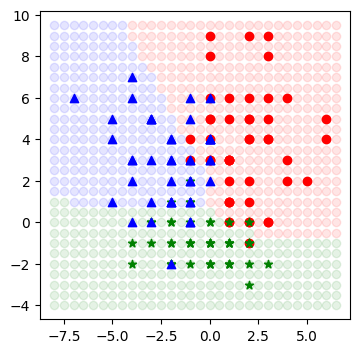

loss : 0.36526696295776484


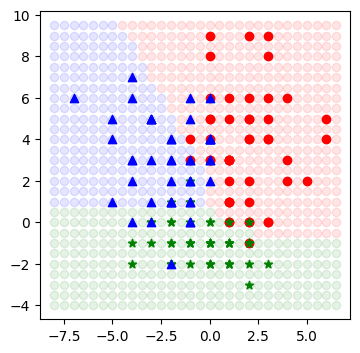

Epoch 20
-------------------------------
loss : 0.03542599253364925


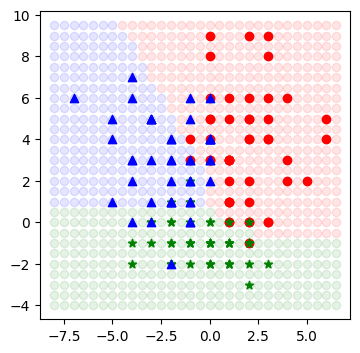

loss : 0.36391047935910886


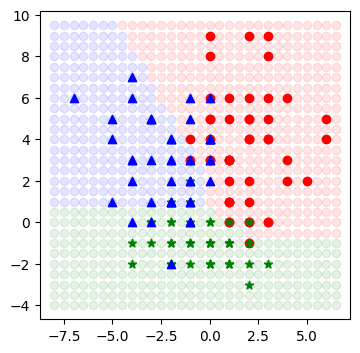

In [8]:
demo_neuron = MulClassDNN(2, 3)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.5, 3)

epochs = 20
m = train_labels.shape[0]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.1)

        if iter_id % (m-1) == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.5, 3)

#Exercise 3
## Use the sklean dataset make_moon and make circle to test yourself implement of DNN

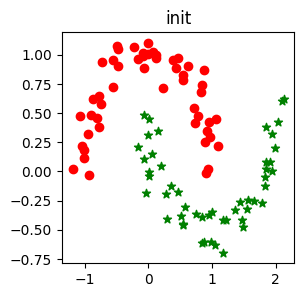

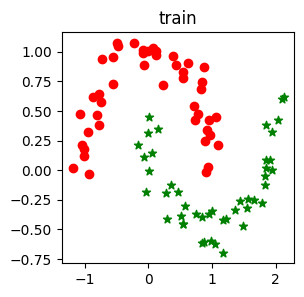

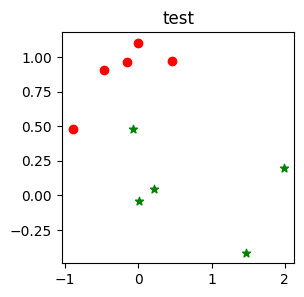

In [15]:
from sklearn.datasets import make_moons, make_circles

size_of_sample = 100
size_of_features = 2
size_of_class = 2
moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=0.1)
"""
figure = plt.figure(figsize=(3,3))
plt.scatter(moon_features[:, 0], moon_features[:, 1], marker='*', c=moon_labels)
plt.show()
"""
labels = np.zeros((size_of_sample, size_of_class))
for i in range(size_of_class):
    labels[np.where(moon_labels == i), i] = 1

train_features, train_labels, test_features, test_labels = split_train_and_test_data(moon_features, labels)

plot_features_and_labels(moon_features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')

In [29]:
class MoonNN:
    def __init__(self, size_of_features=2, size_of_class=2):
        self.L1 = Linear(in_size=size_of_features, out_size=5)
        self.A1 = Sigmoid_Active_Function()
        self.L2 = Linear(in_size=5, out_size=5)
        self.A2 = Sigmoid_Active_Function()
        self.L3 = Linear(in_size=5, out_size=5)
        self.A3 = Sigmoid_Active_Function()
        self.L4 = Linear(in_size=5, out_size=size_of_class)

    def forward(self, X):
        Z = self.L4.forward(self.A3.forward(self.L3.forward(self.A2.forward(self.L2.forward(self.A1.forward(self.L1.forward(X)))))))
        return Z

    def backward(self, E):
        dL_by_dL4 = self.L4.backward(E)
        dL_by_dA3 = self.A3.backward(dL_by_dL4)
        dL_by_dL3 = self.L3.backward(dL_by_dA3)
        dL_by_dA2 = self.A2.backward(dL_by_dL3)
        dL_by_dL2 = self.L2.backward(dL_by_dA2)
        dL_by_dA1 = self.A1.backward(dL_by_dL2)
        dL_by_dL1 = self.L1.backward(dL_by_dA1)
        return dL_by_dL1

    def predict(self, X):
        Z = self.L4.predict(self.A3.predict(self.L3.predict(self.A2.predict(self.L2.predict(self.A1.predict(self.L1.predict(X)))))))
        return Z

    def update_weights(self, learning_rate):
        self.L4.update_weights(learning_rate)
        self.L3.update_weights(learning_rate)
        self.L2.update_weights(learning_rate)
        self.L1.update_weights(learning_rate)


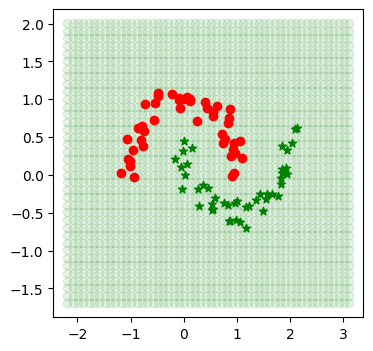

Epoch 1
-------------------------------
loss : 0.11775013144995297


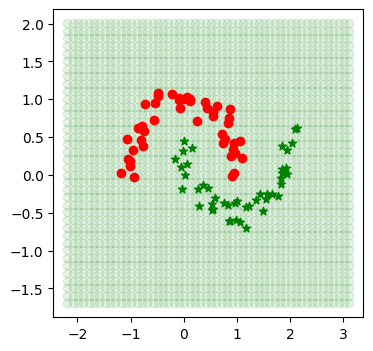

loss : 0.17820924043348055


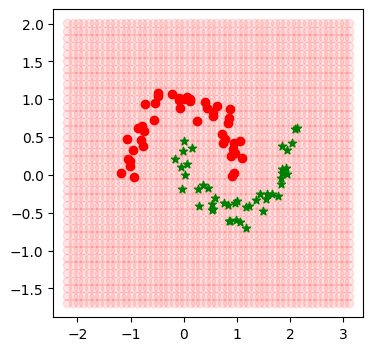

Epoch 2
-------------------------------
loss : 2.089759578647411


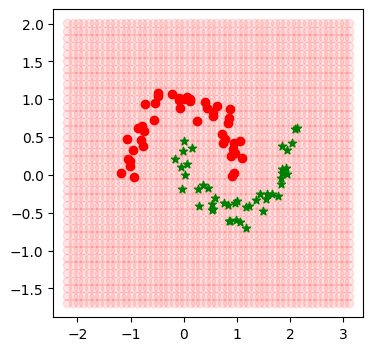

loss : 0.17961998595845297


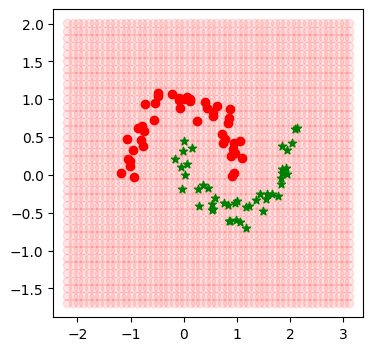

Epoch 3
-------------------------------
loss : 2.04890579845412


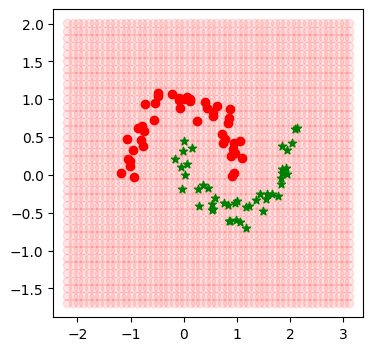

loss : 0.0994450248879033


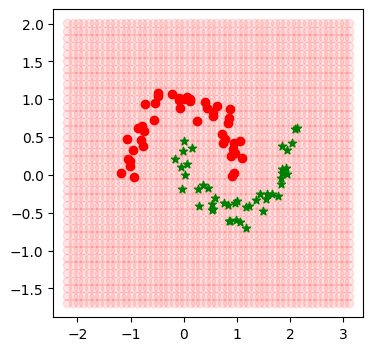

Epoch 4
-------------------------------
loss : 1.6683848332403044


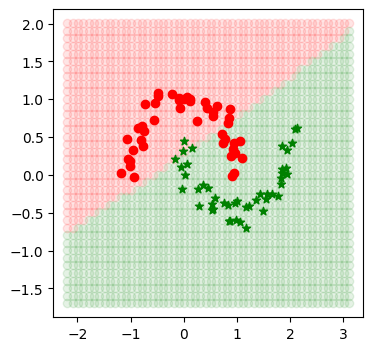

loss : 0.06104557392759729


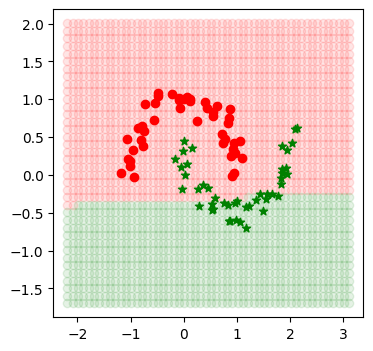

Epoch 5
-------------------------------
loss : 0.483083197452134


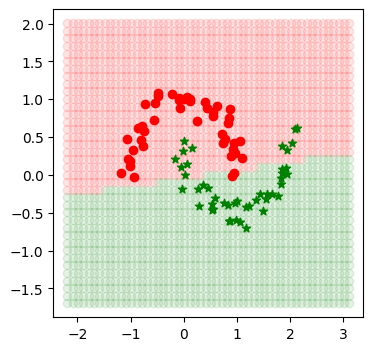

loss : 0.03488521772912111


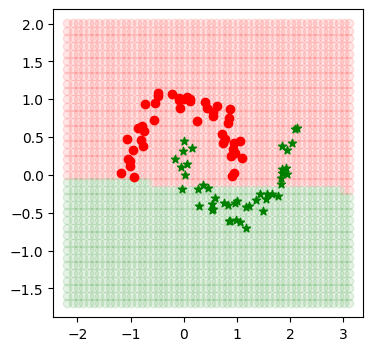

Epoch 6
-------------------------------
loss : 0.06255678647019997


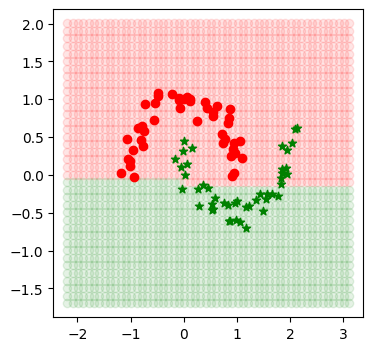

loss : 0.07153175860829579


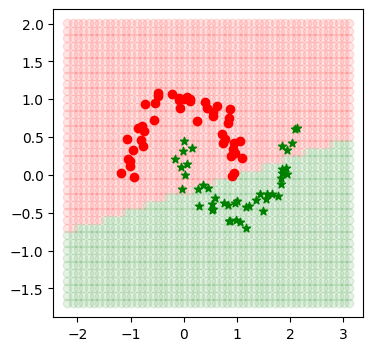

Epoch 7
-------------------------------
loss : 0.007064567623671722


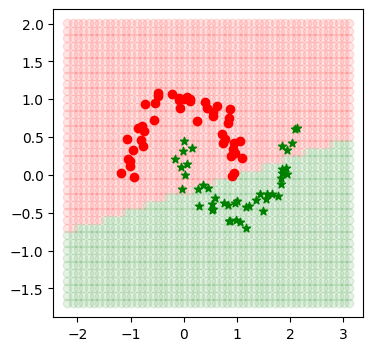

loss : 0.10336004110044128


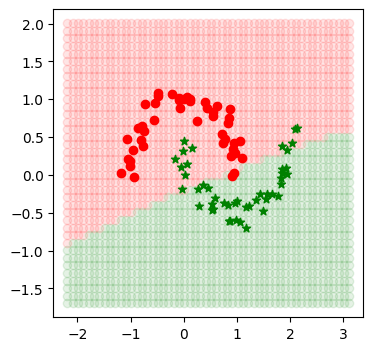

Epoch 8
-------------------------------
loss : 0.03826771456526093


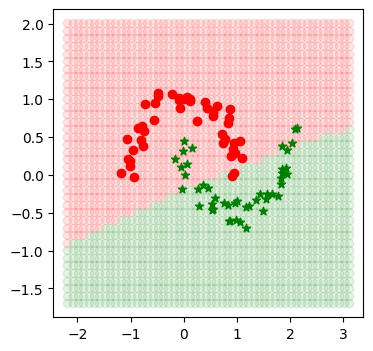

loss : 0.08761227991811472


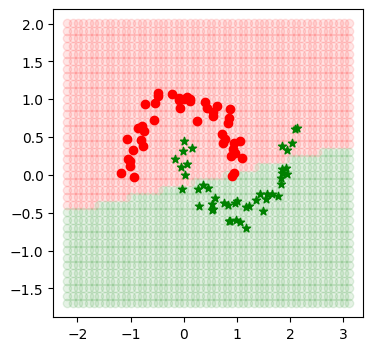

Epoch 9
-------------------------------
loss : 0.005159500419970886


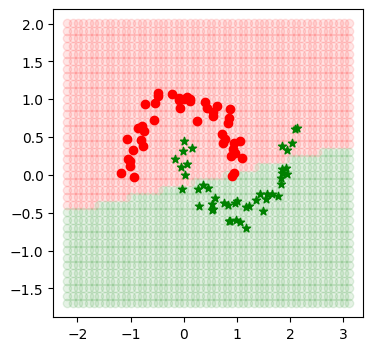

loss : 0.0830741563583029


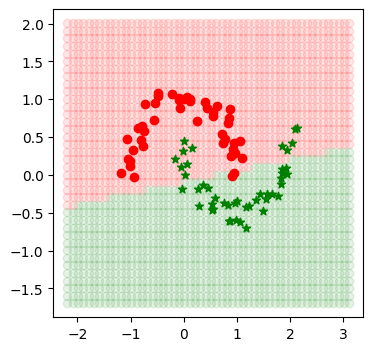

Epoch 10
-------------------------------
loss : 0.003699825173481701


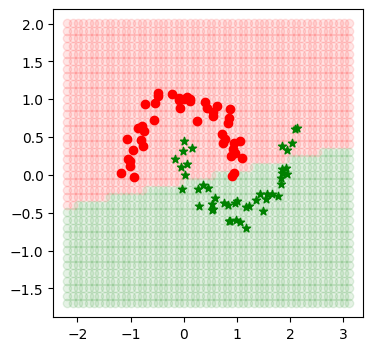

loss : 0.07851636091040964


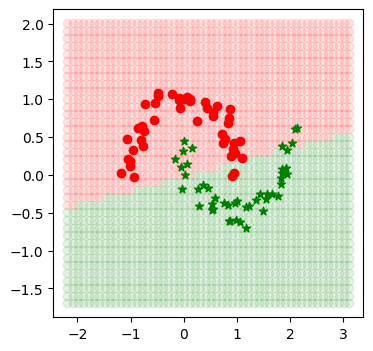

Epoch 11
-------------------------------
loss : 0.0018206345999416144


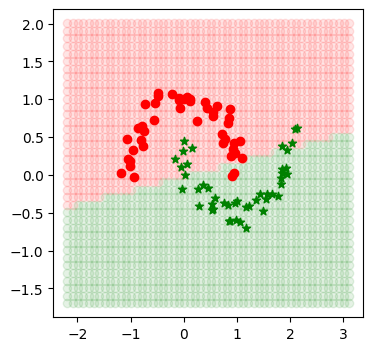

loss : 0.08721458986522286


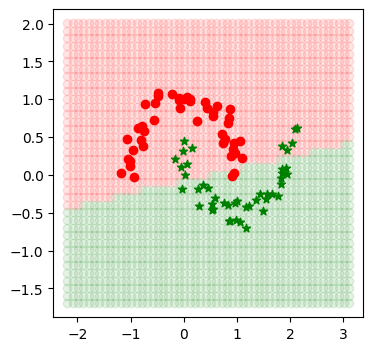

Epoch 12
-------------------------------
loss : 0.00806177685762625


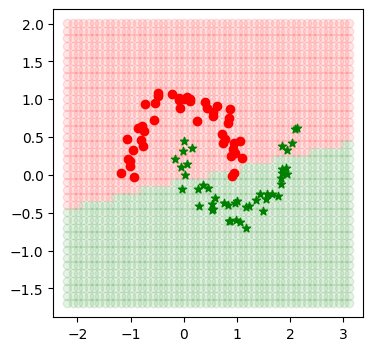

loss : 0.07604786090890217


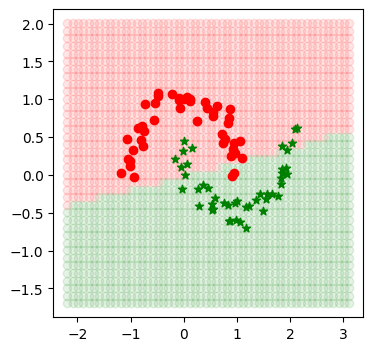

Epoch 13
-------------------------------
loss : 0.001518626352621008


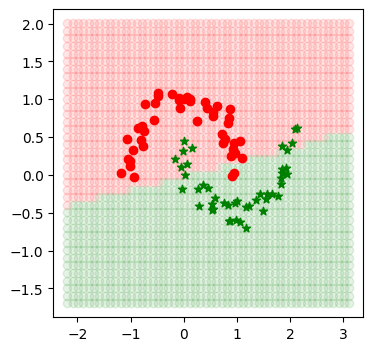

loss : 0.07748162330811977


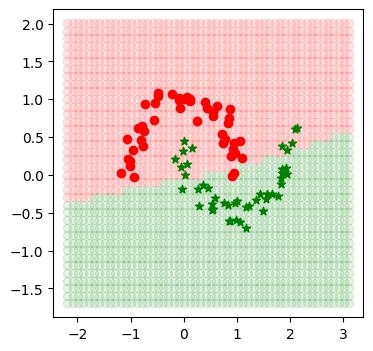

Epoch 14
-------------------------------
loss : 0.00884346779222346


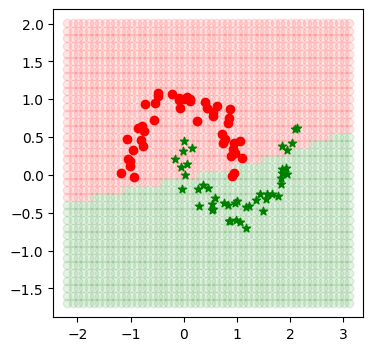

loss : 0.07727820632231934


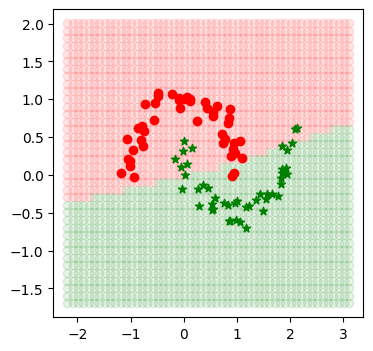

Epoch 15
-------------------------------
loss : 0.00201878531123485


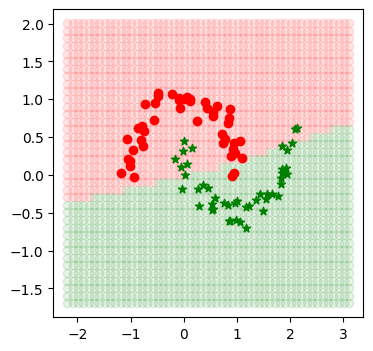

loss : 0.08439681568570953


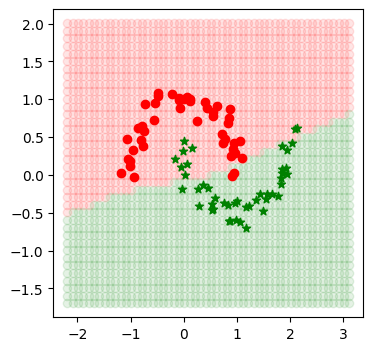

Epoch 16
-------------------------------
loss : 0.0030753880031534186


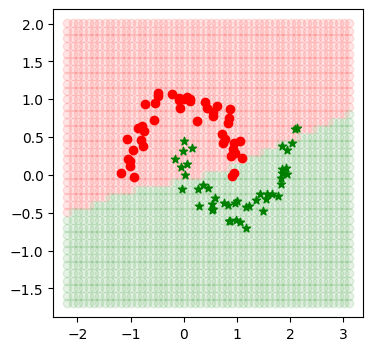

loss : 0.08747662642550065


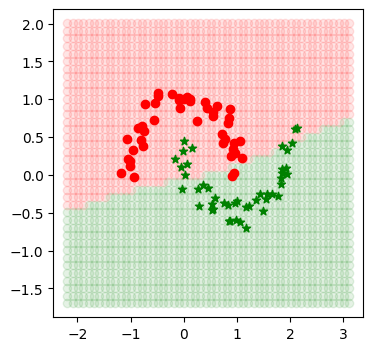

Epoch 17
-------------------------------
loss : 0.0012549680177581014


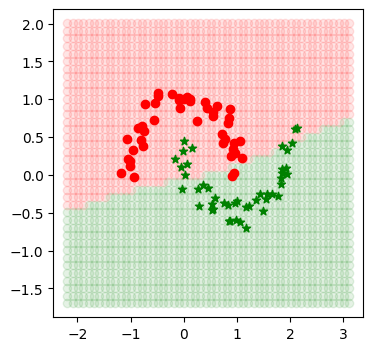

loss : 0.08982049387168574


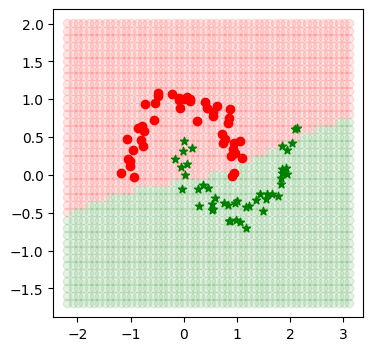

Epoch 18
-------------------------------
loss : 0.001954210339805381


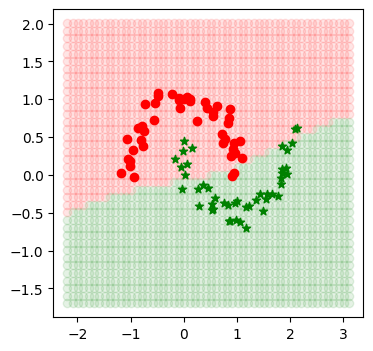

loss : 0.08427710104357194


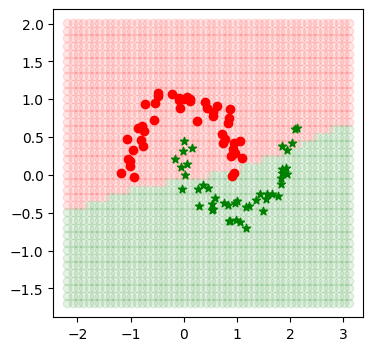

Epoch 19
-------------------------------
loss : 0.0012945577084795435


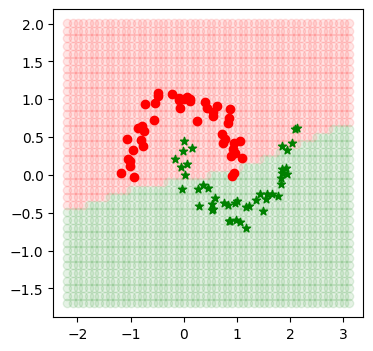

loss : 0.09011182307706794


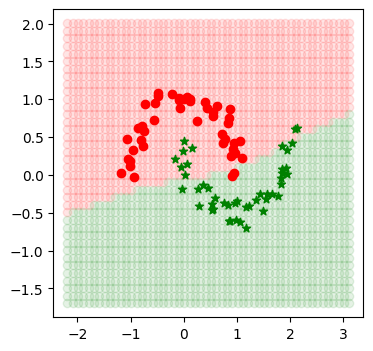

Epoch 20
-------------------------------
loss : 0.0008693648796266583


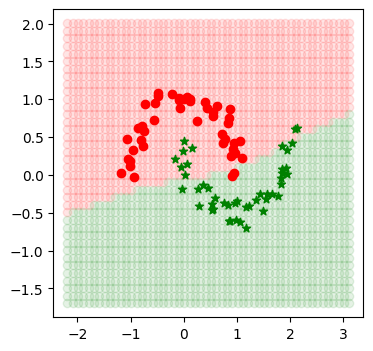

loss : 0.08018389924413744


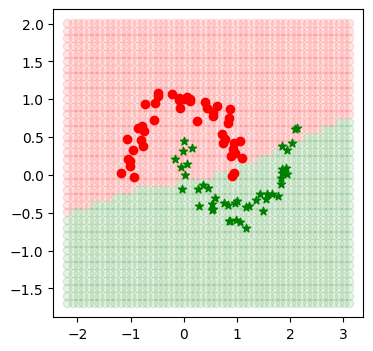

Epoch 21
-------------------------------
loss : 0.0009881235978454275


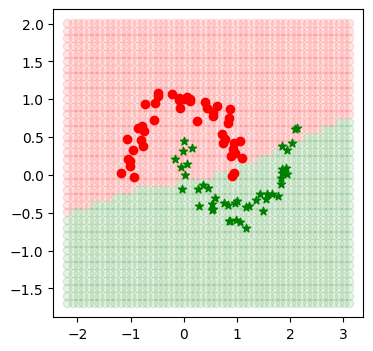

loss : 0.096557099806126


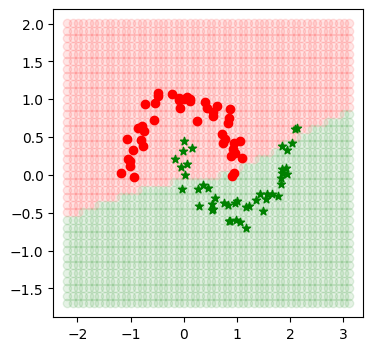

Epoch 22
-------------------------------
loss : 0.0011377230270727874


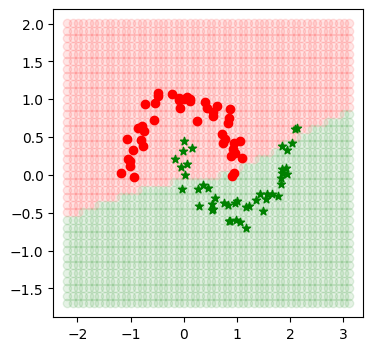

loss : 0.08495720602543146


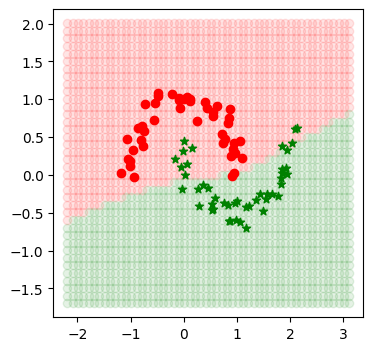

Epoch 23
-------------------------------
loss : 0.0019477356612768028


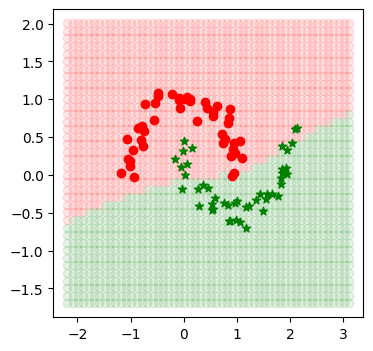

loss : 0.09590247119825476


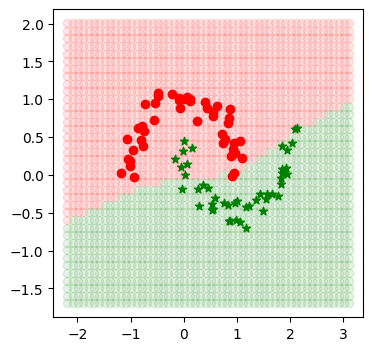

Epoch 24
-------------------------------
loss : 0.0023549090533481827


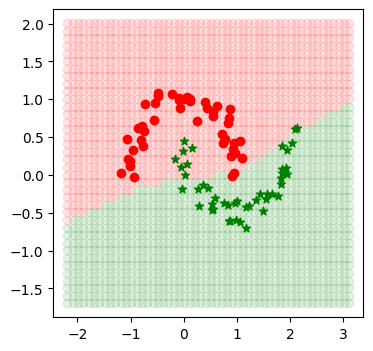

loss : 0.08122817403335411


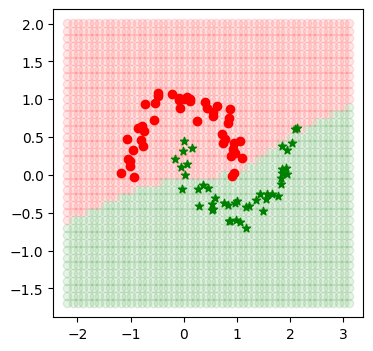

Epoch 25
-------------------------------
loss : 0.0015510971129227046


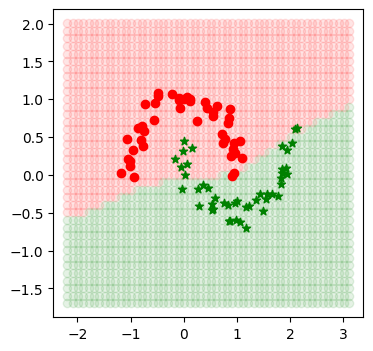

loss : 0.09359135964885675


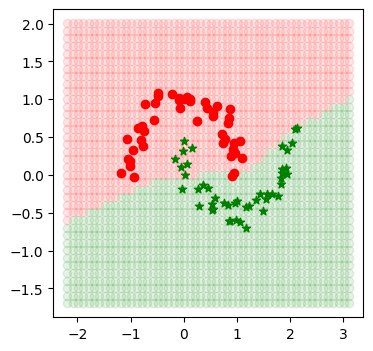

Epoch 26
-------------------------------
loss : 0.0020418058812258543


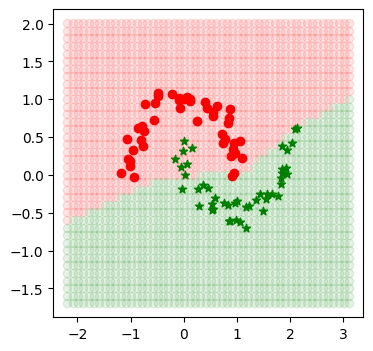

loss : 0.08380248513827893


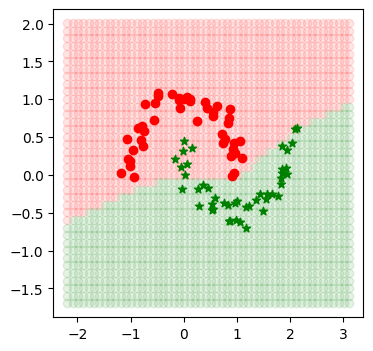

Epoch 27
-------------------------------
loss : 0.0008965339348004641


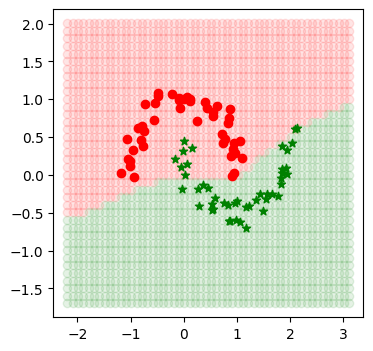

loss : 0.047457597064137796


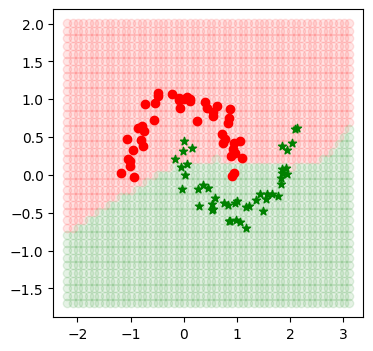

Epoch 28
-------------------------------
loss : 0.0018929708367931804


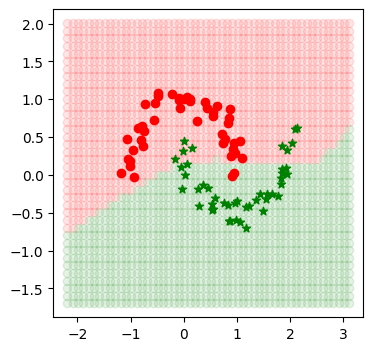

loss : 0.06540889482436361


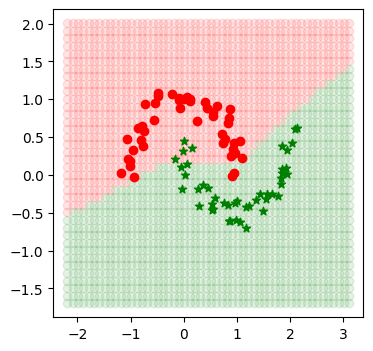

Epoch 29
-------------------------------
loss : 0.0017444039763552634


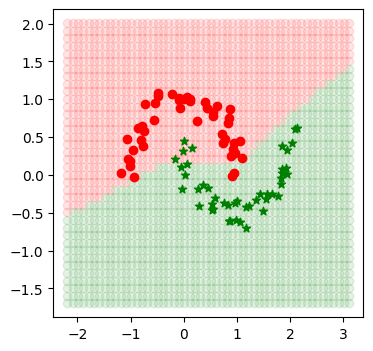

loss : 0.05980944257515919


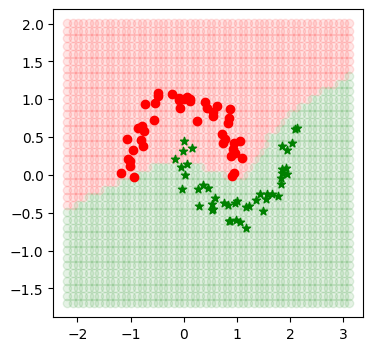

Epoch 30
-------------------------------
loss : 0.001194316494659392


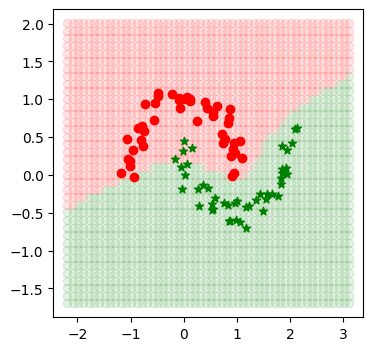

loss : 0.04951110640751884


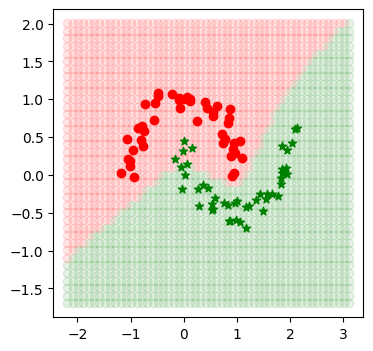

Epoch 31
-------------------------------
loss : 0.0036556001484139527


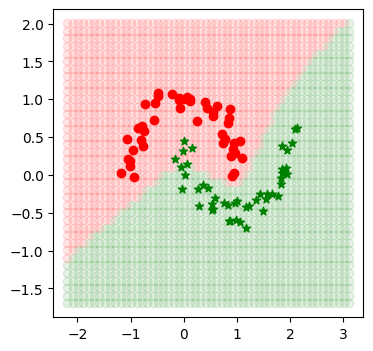

loss : 0.016875461929875886


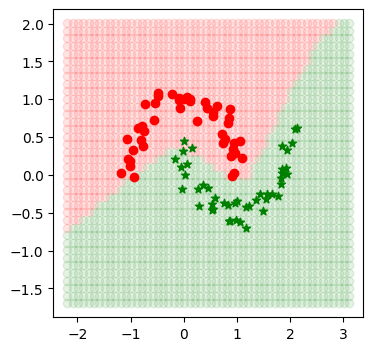

Epoch 32
-------------------------------
loss : 0.0013743929338937368


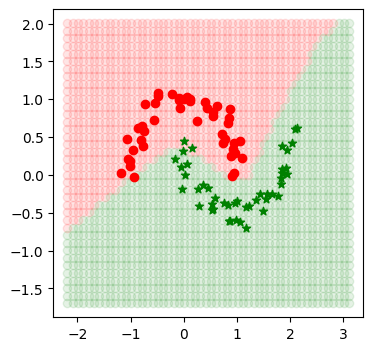

loss : 0.03280098648054401


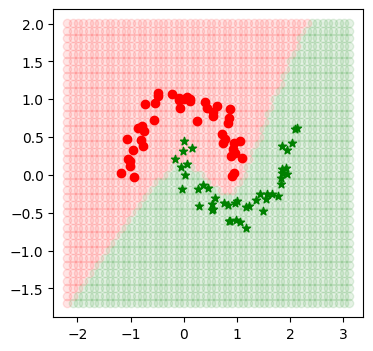

Epoch 33
-------------------------------
loss : 0.015205603466254295


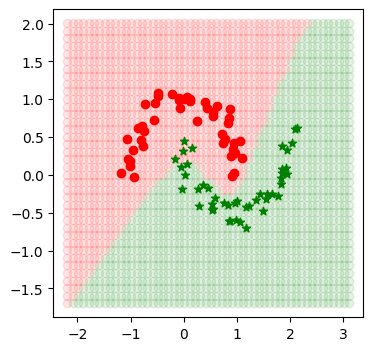

loss : 0.006847388682424626


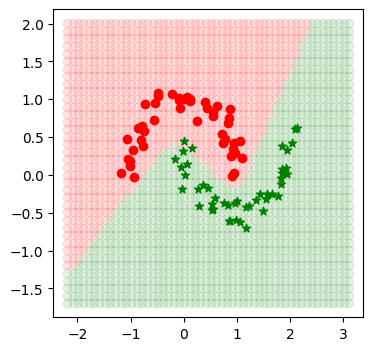

Epoch 34
-------------------------------
loss : 0.002129222198301542


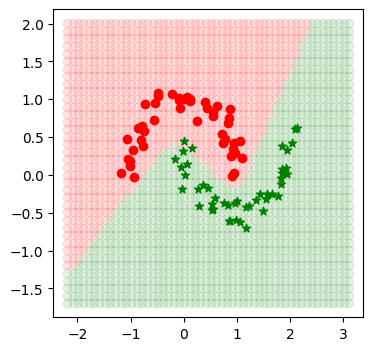

loss : 0.0034762981134536324


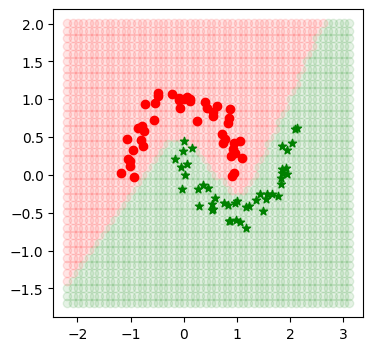

Epoch 35
-------------------------------
loss : 0.006853130082916086


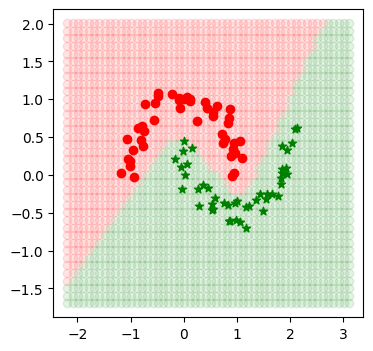

loss : 0.0017660366695788799


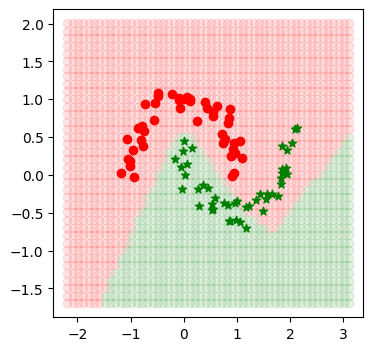

Epoch 36
-------------------------------
loss : 0.3679705272361275


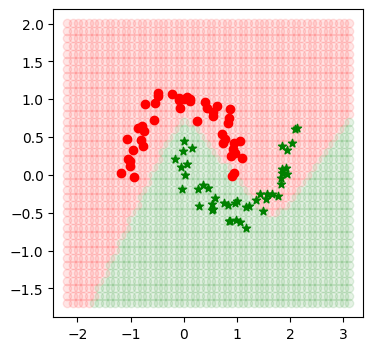

loss : 0.0015404311769675006


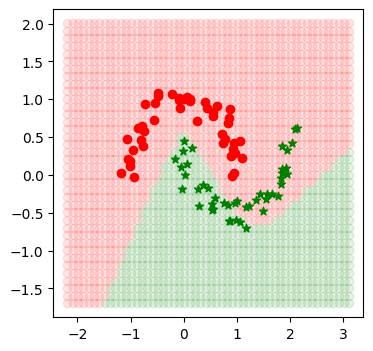

Epoch 37
-------------------------------
loss : 3.8175596839118247


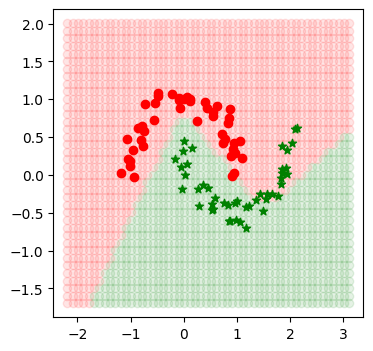

loss : 0.003323931038050038


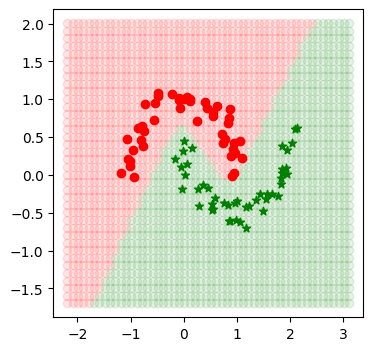

Epoch 38
-------------------------------
loss : 0.01428733913285552


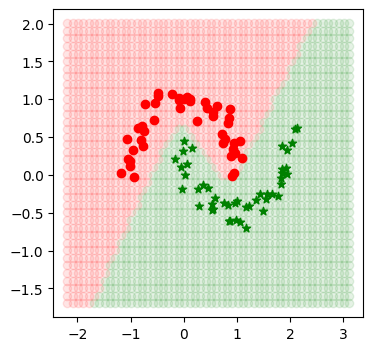

loss : 0.0022943431056844303


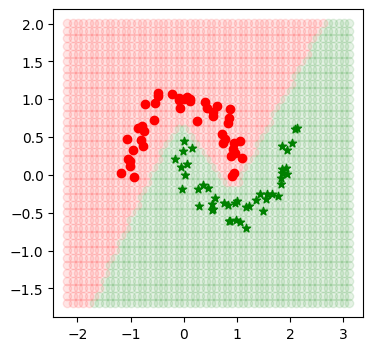

Epoch 39
-------------------------------
loss : 0.003292032261158484


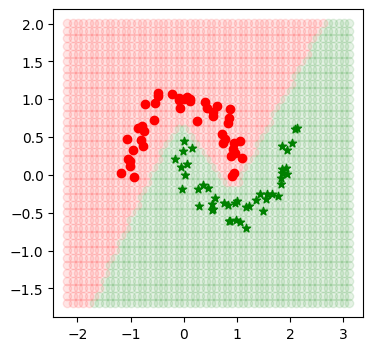

loss : 0.0017569964569884029


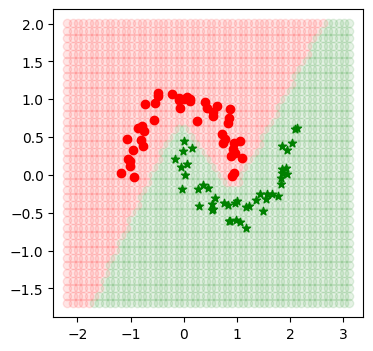

Epoch 40
-------------------------------
loss : 0.0017672021548108424


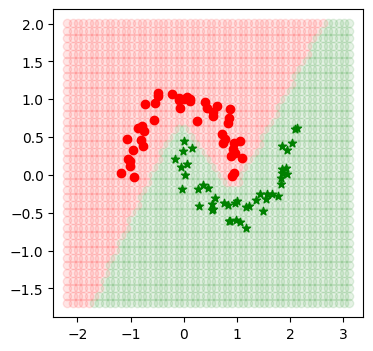

loss : 0.0013860824025494025


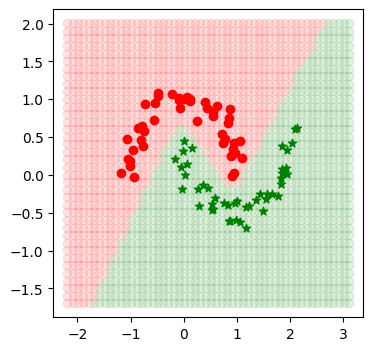

Epoch 41
-------------------------------
loss : 0.0012138385764184814


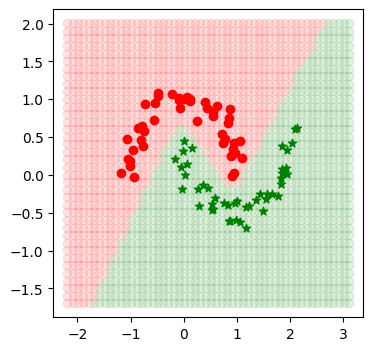

loss : 0.0011367222359388468


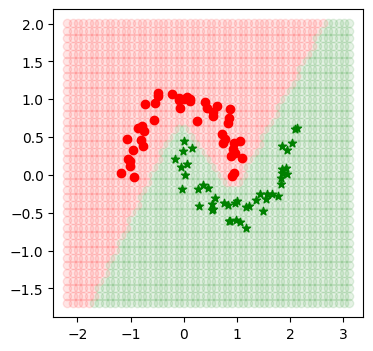

Epoch 42
-------------------------------
loss : 0.000923089278799777


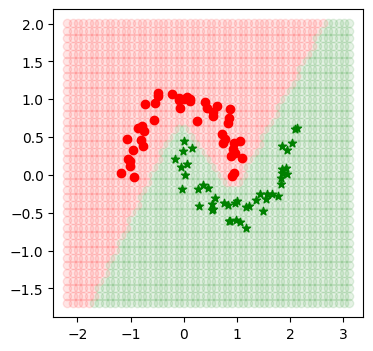

loss : 0.0009606153353144449


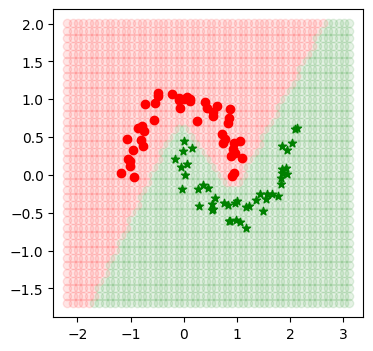

Epoch 43
-------------------------------
loss : 0.0007433277904608509


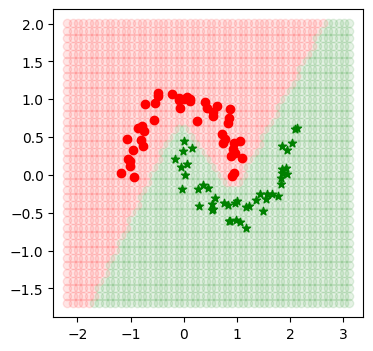

loss : 0.0008304151778466631


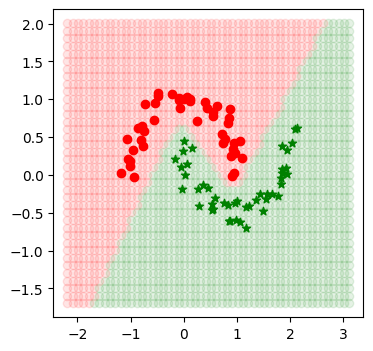

Epoch 44
-------------------------------
loss : 0.0006212168847359646


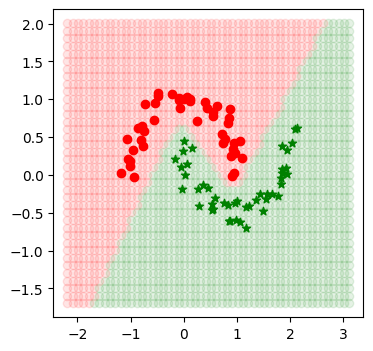

loss : 0.0007305298303417889


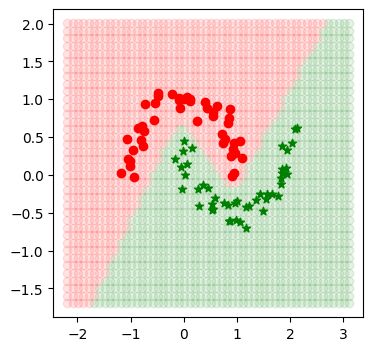

Epoch 45
-------------------------------
loss : 0.000532940498263233


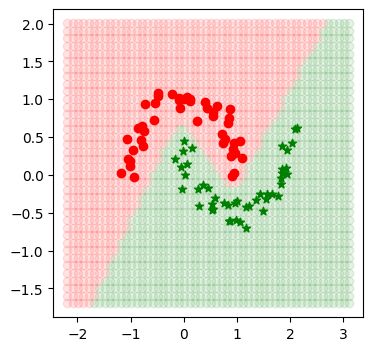

loss : 0.0006516036493965844


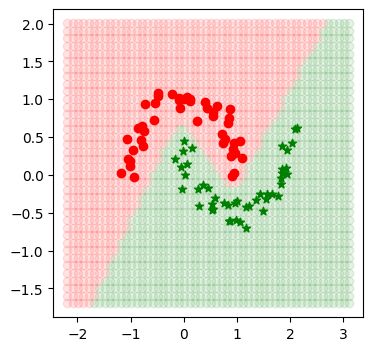

Epoch 46
-------------------------------
loss : 0.000466216310009192


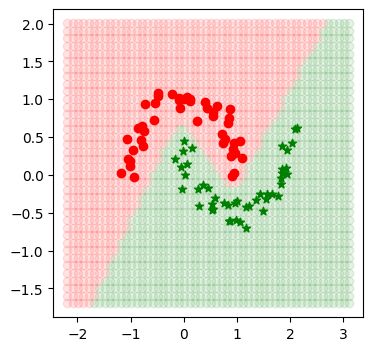

loss : 0.000587731445139997


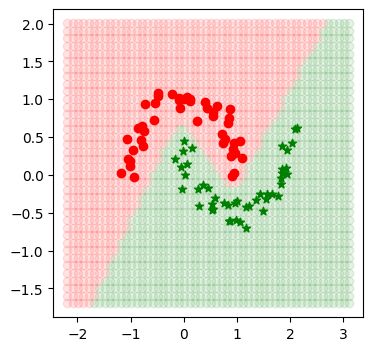

Epoch 47
-------------------------------
loss : 0.0004140587632363973


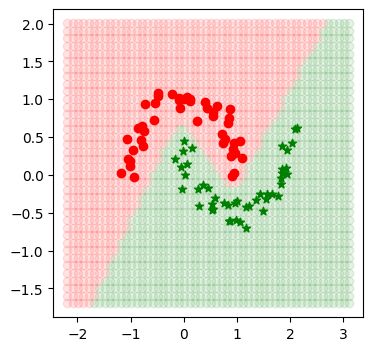

loss : 0.0005350182680687718


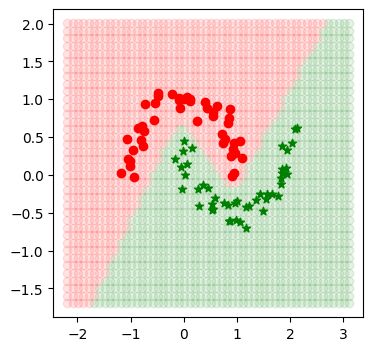

Epoch 48
-------------------------------
loss : 0.00037220053937469627


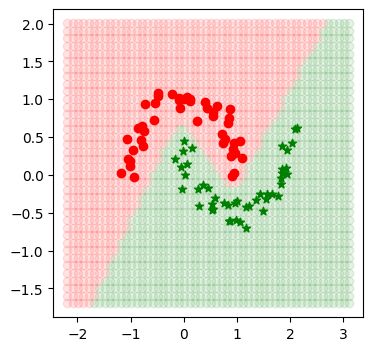

loss : 0.00049079743838167


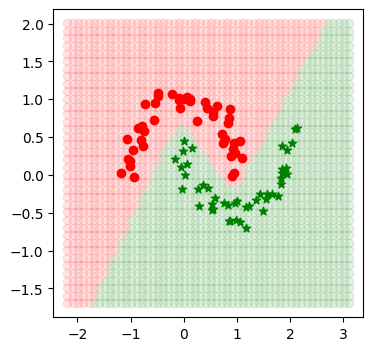

Epoch 49
-------------------------------
loss : 0.00033788810537603787


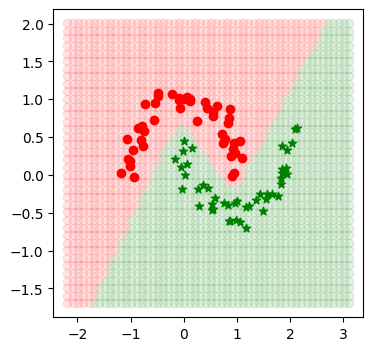

loss : 0.00045318456513714984


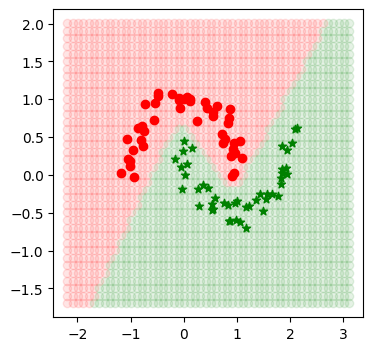

Epoch 50
-------------------------------
loss : 0.0003092658056529616


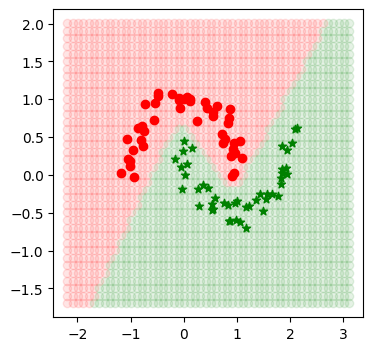

loss : 0.0004208116492116098


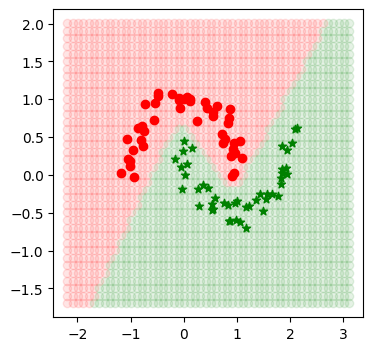

Epoch 51
-------------------------------
loss : 0.00028503800937478073


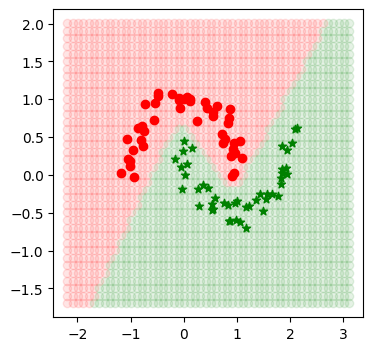

loss : 0.0003926622537930629


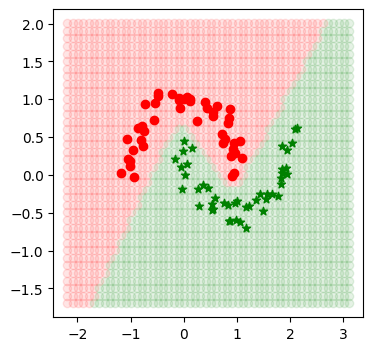

Epoch 52
-------------------------------
loss : 0.0002642730589751246


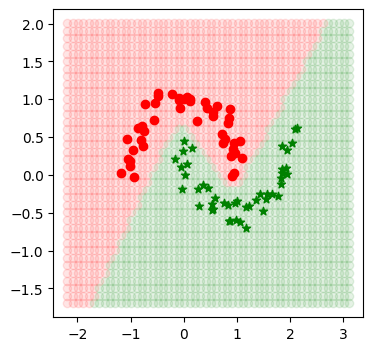

loss : 0.00036796578836634653


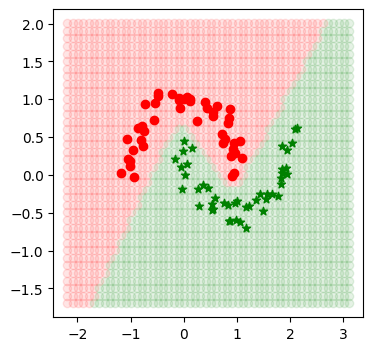

Epoch 53
-------------------------------
loss : 0.00024628412211488617


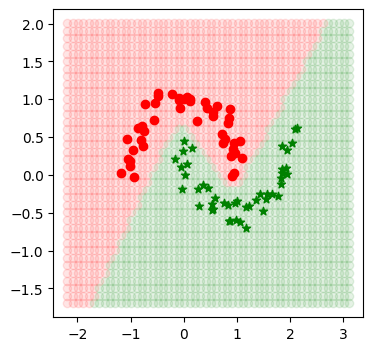

loss : 0.0003461276550797432


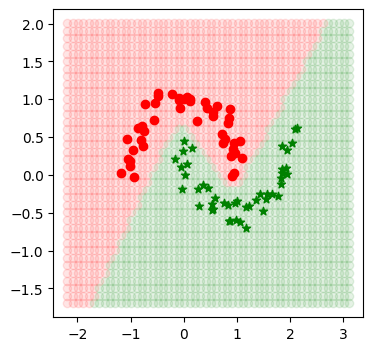

Epoch 54
-------------------------------
loss : 0.00023055392124126848


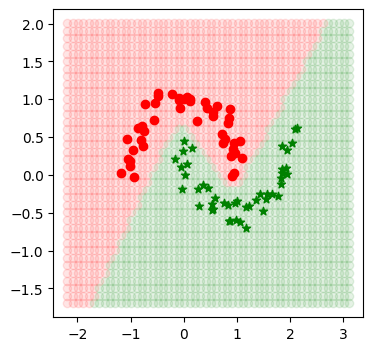

loss : 0.00032668186585419823


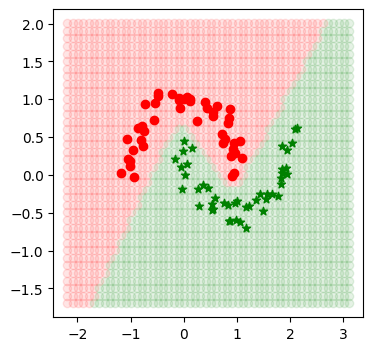

Epoch 55
-------------------------------
loss : 0.00021668558825354084


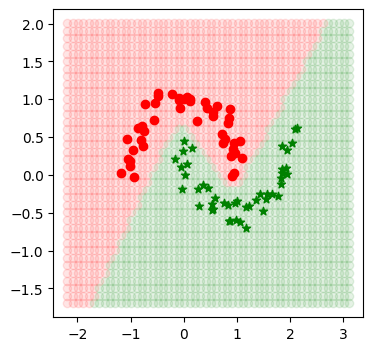

loss : 0.0003092581477540439


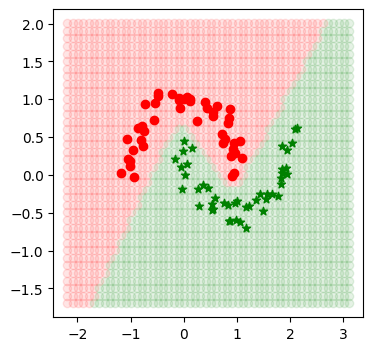

Epoch 56
-------------------------------
loss : 0.0002043696509376244


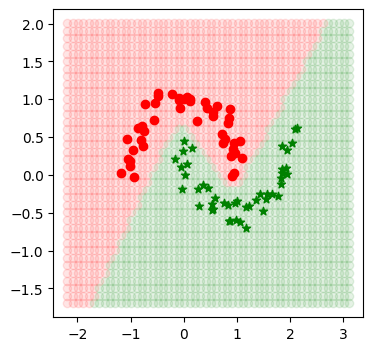

loss : 0.00029355863046024474


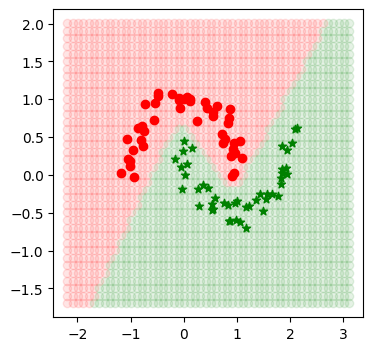

Epoch 57
-------------------------------
loss : 0.00019336129899043004


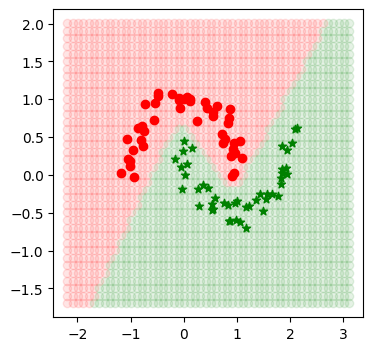

loss : 0.0002793410167485823


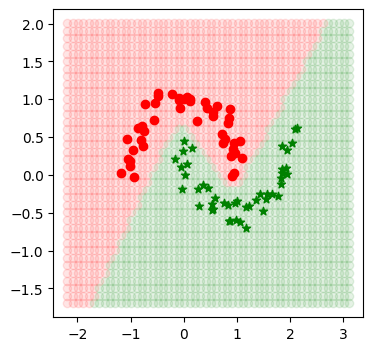

Epoch 58
-------------------------------
loss : 0.00018346438318863337


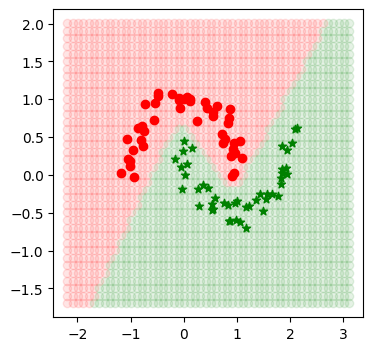

loss : 0.0002664062296438169


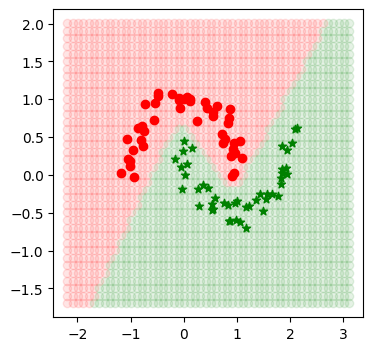

Epoch 59
-------------------------------
loss : 0.0001745199331262542


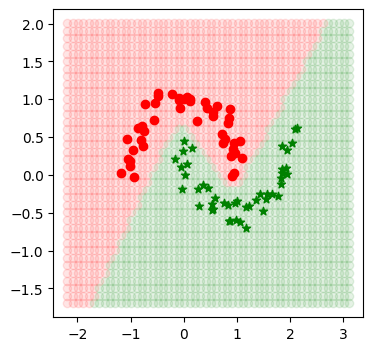

loss : 0.00025458920829306254


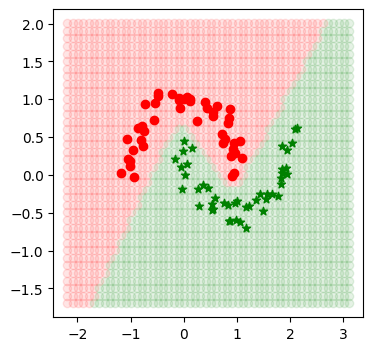

Epoch 60
-------------------------------
loss : 0.00016639777348512045


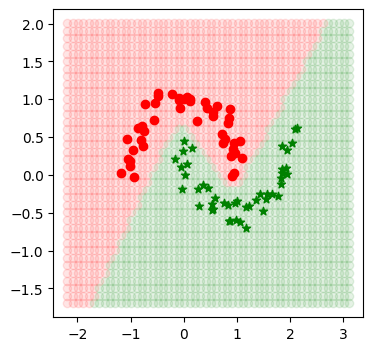

loss : 0.00024375195580837977


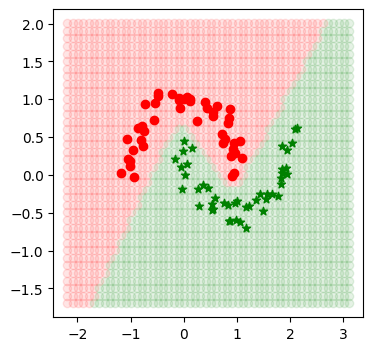

Epoch 61
-------------------------------
loss : 0.00015899030653889376


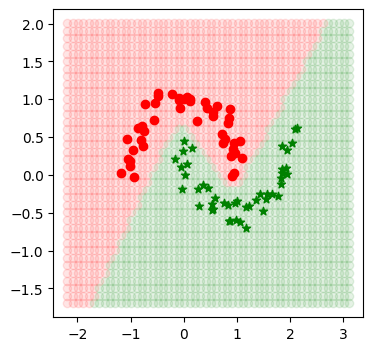

loss : 0.00023377822238173753


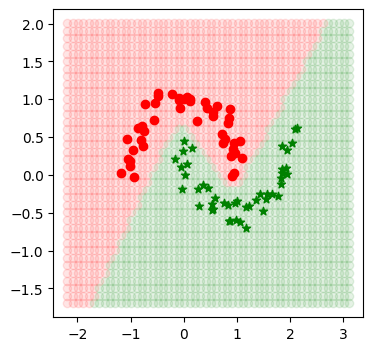

Epoch 62
-------------------------------
loss : 0.00015220783570053713


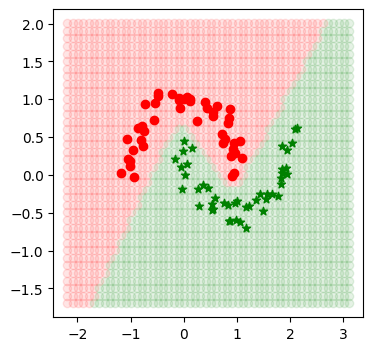

loss : 0.000224569392469485


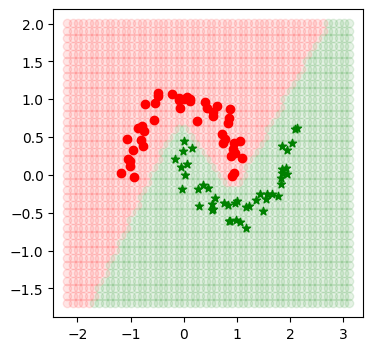

Epoch 63
-------------------------------
loss : 0.00014597500278651251


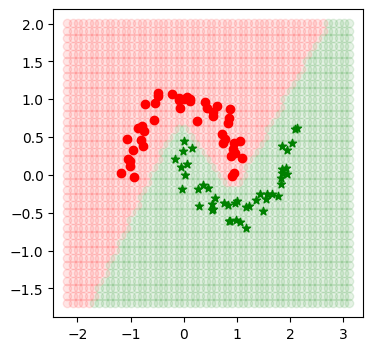

loss : 0.00021604126991062465


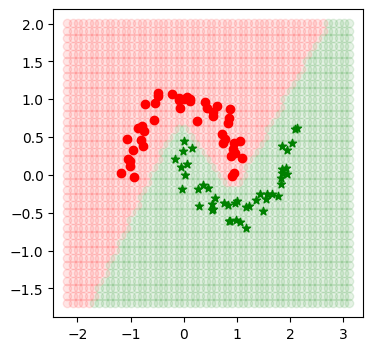

Epoch 64
-------------------------------
loss : 0.00014022804181125365


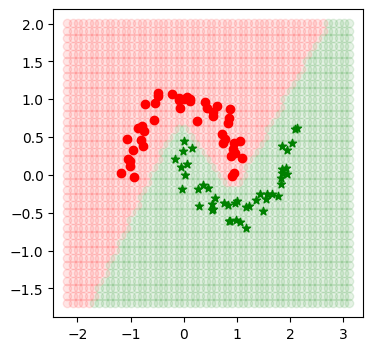

loss : 0.00020812154057921073


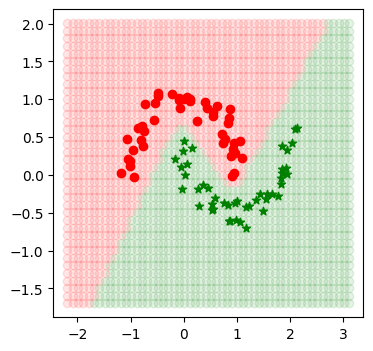

Epoch 65
-------------------------------
loss : 0.00013491263933243383


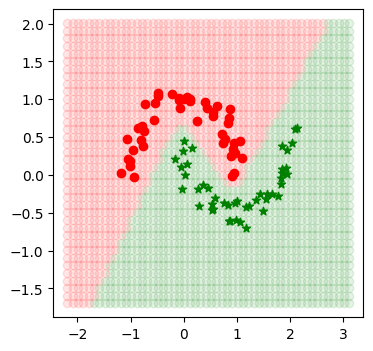

loss : 0.00020074775183786728


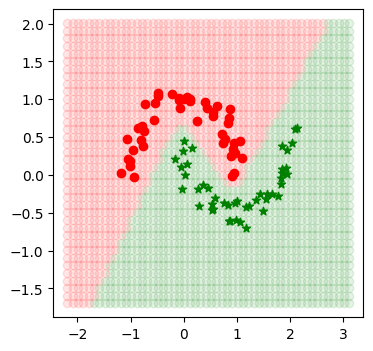

Epoch 66
-------------------------------
loss : 0.00012998225083508215


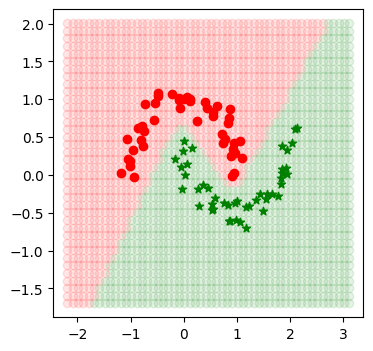

loss : 0.0001938656901595219


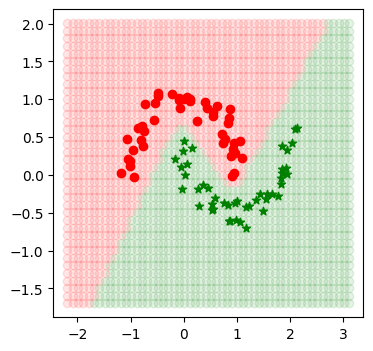

Epoch 67
-------------------------------
loss : 0.00012539676381745796


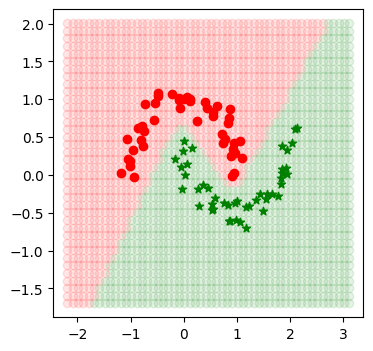

loss : 0.00018742806839458653


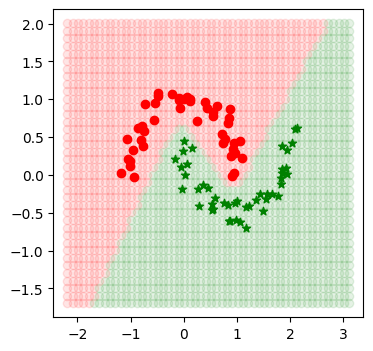

Epoch 68
-------------------------------
loss : 0.00012112142717492134


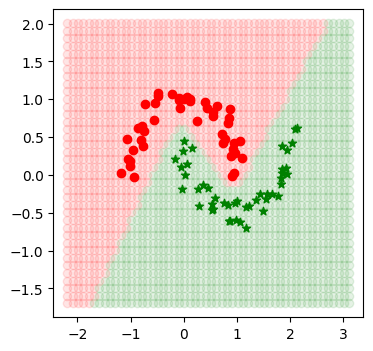

loss : 0.00018139345593298764


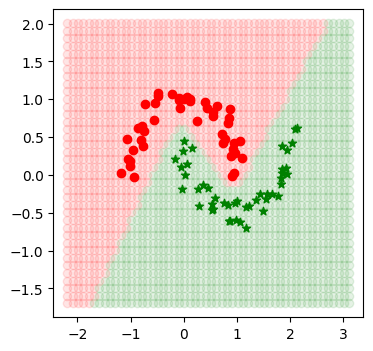

Epoch 69
-------------------------------
loss : 0.00011712598708416096


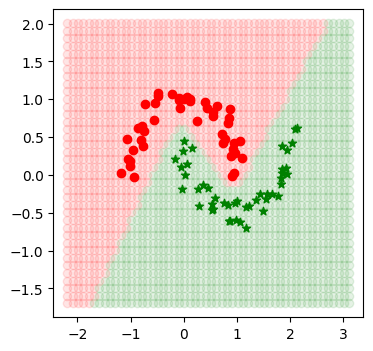

loss : 0.00017572540095403267


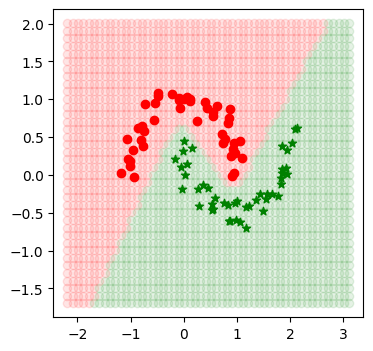

Epoch 70
-------------------------------
loss : 0.00011338398443661566


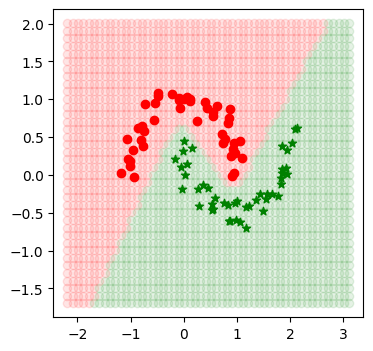

loss : 0.00017039170573687545


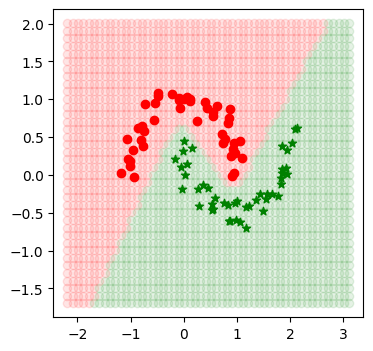

Epoch 71
-------------------------------
loss : 0.00010987217970788984


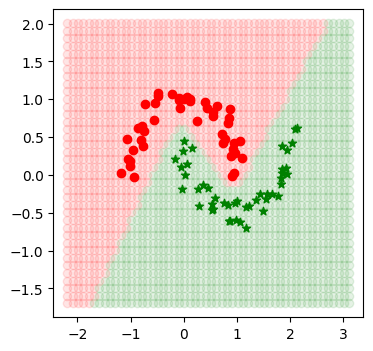

loss : 0.0001653638248050316


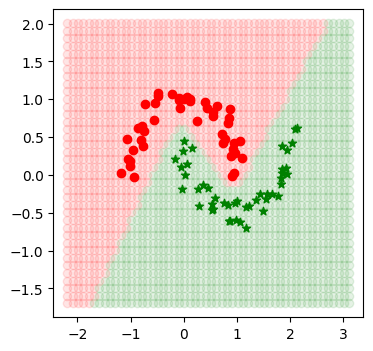

Epoch 72
-------------------------------
loss : 0.00010657007912802762


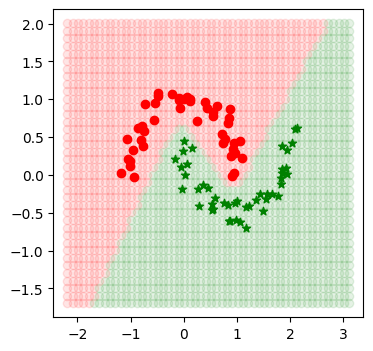

loss : 0.000160616362305253


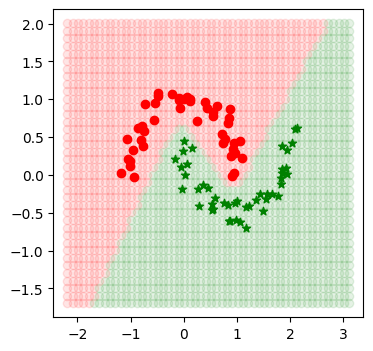

Epoch 73
-------------------------------
loss : 0.00010345954196303123


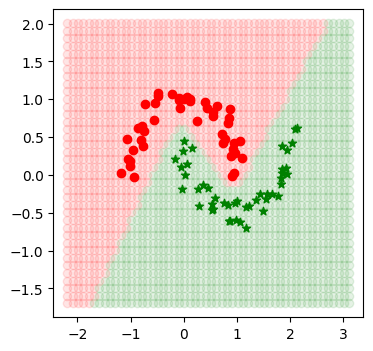

loss : 0.00015612665006157735


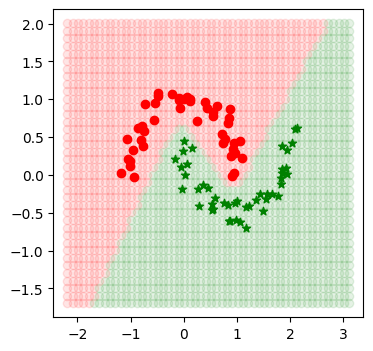

Epoch 74
-------------------------------
loss : 0.00010052445318248454


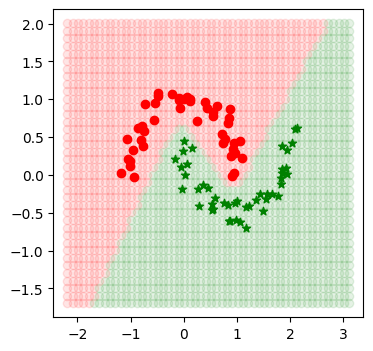

loss : 0.00015187439160673725


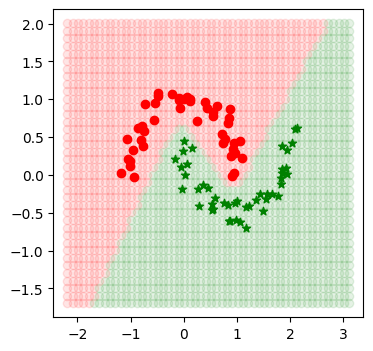

Epoch 75
-------------------------------
loss : 9.775044917873284e-05


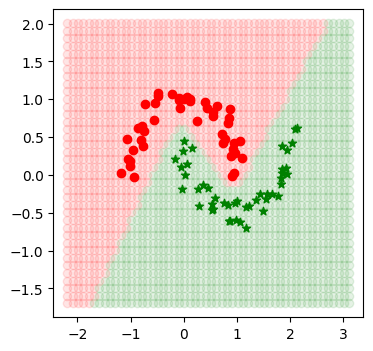

loss : 0.00014784136046885082


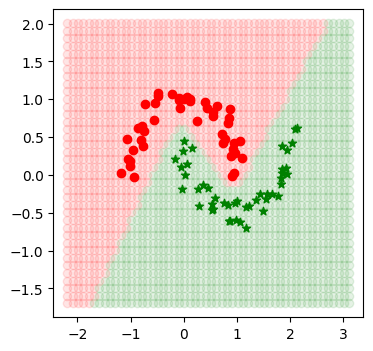

Epoch 76
-------------------------------
loss : 9.512468678074459e-05


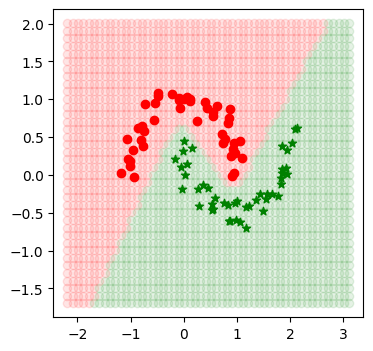

loss : 0.00014401114331999857


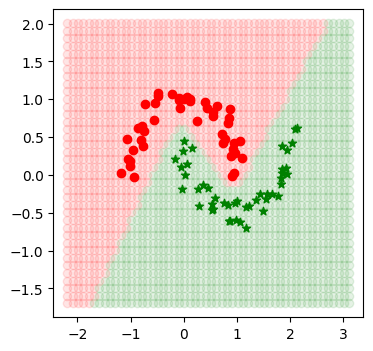

Epoch 77
-------------------------------
loss : 9.263564781180937e-05


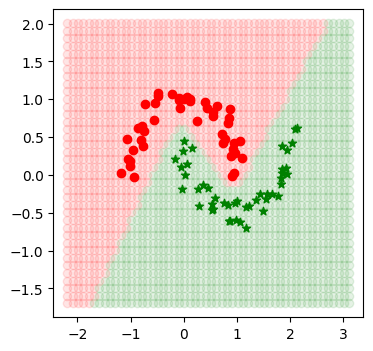

loss : 0.00014036892039230605


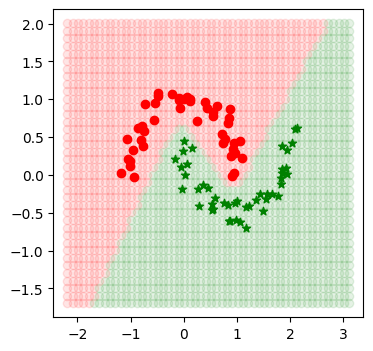

Epoch 78
-------------------------------
loss : 9.027297297583612e-05


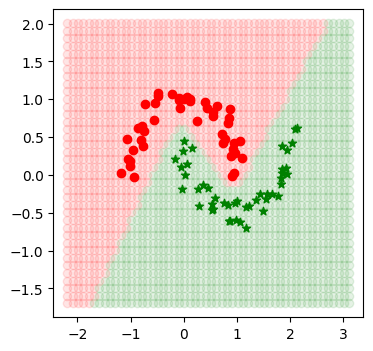

loss : 0.00013690127701458318


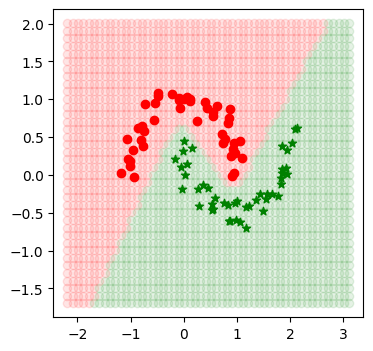

Epoch 79
-------------------------------
loss : 8.802732007381644e-05


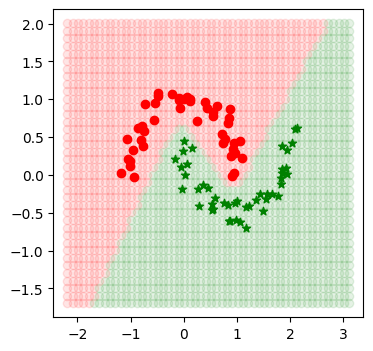

loss : 0.00013359604124268989


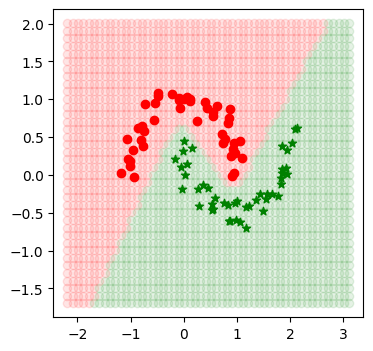

Epoch 80
-------------------------------
loss : 8.589024249501901e-05


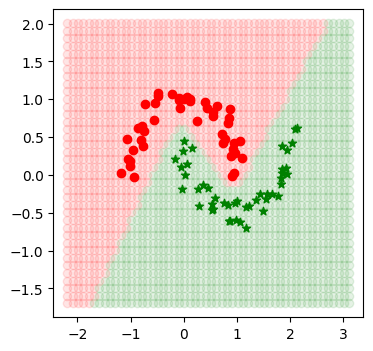

loss : 0.0001304421434709086


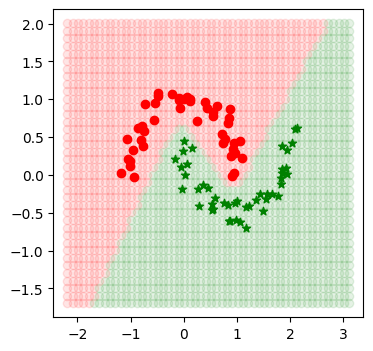

In [32]:
demo_neuron = MoonNN(2, 2)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 1)

        if iter_id % (m-1) == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)